In [1]:
import os
import subprocess
import torch
import re
os.chdir('../')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy

from IPython.display import HTML as html_print
from research.utils import load_vocabulary, Tokenizer, Aligner, RelaxedTargetField, OneHotEncoder, bleu
from research.scorer import Scorer
from research.greedy_optimizer import GreedyOptimizer
from research.beam_optimizer import BeamOptimizer
from research.continuous_optimizer import ContinuousOptimizer
from research.exponentiated_gradient_optimizer import ExponentiatedGradientOptimizer

### Model loading

In [2]:
vocab = load_vocabulary()
tokenizer = Tokenizer()
scorer = Scorer()
one_hot_encoder = OneHotEncoder(vocab)

### Translation scoring

In [3]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
german_translation_from_google = 'Ich denke, dass maschinelle Übersetzung ein sehr interessantes Thema ist.'
score = scorer.score_texts(english_sentence, german_translation_from_google)
print('Translation scoring')
print('English sentence:', english_sentence)
print('Translation from google translate to score:', german_translation_from_google)
print('Log likehood of translation:', score[0])

Translation scoring
English sentence: I think, that machine translation is a very interesting subject.
Translation from google translate to score: Ich denke, dass maschinelle Übersetzung ein sehr interessantes Thema ist.
Log likehood of translation: -6.253188


### Predicting of next word in translation

In [4]:
unfinished_translation = 'Ich denke, dass maschinelle Übersetzung ein sehr'
english_tokens = tokenizer.tokenize(english_sentence)
german_tokens = tokenizer.tokenize(unfinished_translation)
next_word_probs = scorer.next_word_probabilities([english_tokens], [german_tokens])
val, ind = next_word_probs.topk(3)
print('English sentence:', english_sentence)
print('Unfinished translation:', unfinished_translation )
print('Top 3 next tokens: ', vocab.itos[ind[0,0].view(-1)], vocab.itos[ind[0,1].view(-1)], vocab.itos[ind[0,2].view(-1)])

English sentence: I think, that machine translation is a very interesting subject.
Unfinished translation: Ich denke, dass maschinelle Übersetzung ein sehr
Top 3 next tokens:  ▁interessante ▁interessant ▁Interessant


### Greedy optimization

In [5]:
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = GreedyOptimizer(english_sentence)
print('Optimizer initialized...')
german_tokens = optimizer.optimize()[:-1]
score = scorer.score_tokenized_texts([english_tokens], [german_tokens])[0]
print('English sentence:', english_sentence)
print('Translated tokens', ' '.join(german_tokens))
print(f'Log likehood of translation: {score:.2f}')

Optimizer initialized...
English sentence: I think, that machine translation is a very interesting subject.
Translated tokens ▁Ich ▁denke , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist .
Log likehood of translation: -5.41


### Beam search optimization

In [6]:
n_beams = 15
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I think, that machine translation is a very interesting subject.
Top 15 translations:
1. ▁Ich ▁denke , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -5.41]
2. ▁Ich ▁glaube , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -5.74]
3. ▁Ich ▁halte ▁die ▁ maschine lle ▁Übersetzung ▁für ▁ein ▁sehr ▁interessante s ▁Thema . [p = -5.77]
4. ▁Ich ▁denke , ▁dass ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.25]
5. ▁Ich ▁glaube , ▁dass ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.65]
6. ▁Ich ▁finde , ▁dass ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema ▁ist . [p = -6.70]
7. ▁Ich ▁denke , ▁die ▁ maschine lle ▁Übersetzung ▁ist ▁ein ▁sehr ▁interessante s ▁Thema . [p = -6.87]
8. ▁Meine s ▁Era chtens ▁ist ▁die ▁ maschine lle ▁Übersetzung ▁ein ▁sehr ▁interessante s ▁Thema . [p = -7.14]
9. ▁Ich ▁denke , ▁da

### Entropy of conditional probabilities for each word in different translations

In [7]:
def plot_entropies(i):
    plt.title('Entropy for each word in different translations')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    trans = translations[i][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    words = list(range(probs.shape[0]))
    entropies = [entropy(probs[k, :]) for k in words]
    plt.scatter(words, entropies, label=f'Translation {i}')
    print(f'Translation {i}:\n{" | ".join(trans)}')
    print()
    plt.legend()

def plot_aligned_entropies(i, j):
    plt.title('Entropy for each word in different translations (aligned)')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    
    aligner = Aligner()
    trans_i = translations[i][:-1]
    trans_j = translations[j][:-1]
    aligned_i, aligned_j = aligner.align(trans_i, trans_j)
    
    logprobs_i = scorer.score_probabilities_for_each_word(english_tokens, trans_i)
    probs_i = np.exp(logprobs_i)
    logprobs_j = scorer.score_probabilities_for_each_word(english_tokens, trans_j)
    probs_j = np.exp(logprobs_j)

    words = np.arange(len(aligned_i))
    entropies_i = []
    k = 0
    for word in aligned_i:
        if word == '[PLACEHOLDER]':
            entropies_i += [-1.]
        else:
            entropies_i += [entropy(probs_i[k, :])]
            k += 1
    entropies_i = np.array(entropies_i)
    
    entropies_j = []
    k = 0
    for word in aligned_j:
        if word == '[PLACEHOLDER]':
            entropies_j += [-1.]
        else:
            entropies_j += [entropy(probs_j[k, :])]
            k += 1
    entropies_j = np.array(entropies_j)
    
    plt.scatter(words[entropies_i >= 0.], entropies_i[entropies_i >= 0.], label=f'Translation {i}')
    plt.scatter(words[entropies_j >= 0.], entropies_j[entropies_j >= 0.], label=f'Translation {j}')
    print(f'Translation {i}:\n{" | ".join(aligned_i)}')
    print(f'Translation {j}:\n{" | ".join(aligned_j)}')
    print()
    plt.legend()
    
def plot_maxs(i):
    plt.title('Max for each word in different translations')
    plt.xlabel('Word number')
    plt.ylabel('Max')
    trans = translations[i][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    words = list(range(probs.shape[0]))
    entropies = [np.max(probs[k, :]) for k in words]
    plt.scatter(words, entropies, label=f'Translation {i}')
    print(f'Translation {i}:\n{" | ".join(trans)}')
    print()
    plt.legend()
    
def other_candidates(trans_idx, pos, N = 4):
    trans = translations[trans_idx][:-1]
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, trans)
    probs = np.exp(logprobs)
    other_good_choices = np.argsort(probs[pos])[:-6:-1]
    print('Best candidates on position', pos, ': ', ' '.join([vocab.itos[idx] for idx in other_good_choices]))
    print('Coresponding probabilities:', [probs[pos][idx] for idx in other_good_choices])    

#### Comparison of the best and the worst translation

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .

Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



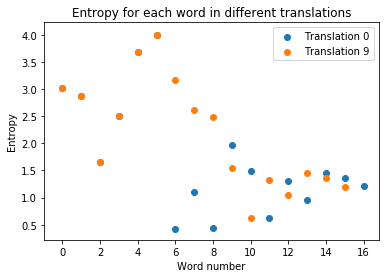

In [8]:
for i in [0, 9]:
    plot_entropies(i)
plt.show()

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .

Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



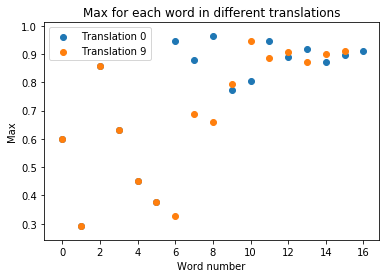

In [9]:
for i in [0, 9]:
    plot_maxs(i)
plt.show()

Entropia z jakiegoś powodu jest bardzo słabą miarą (chyba, że bug). Entropia dla pozycji 0 w zdaniu 9 niewiele różni się od entropi na pozycji 1 w zdaniu 9, a te rozkłady są zupełnie różne (na pozycji 0 mamy tylko 1 prawdopodobną wartość, a na pozycji 1 aż 4). Przykład poniżej:

#### Entropies of alligned sentences

Best vs worst translation:

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 9:
▁Ich | ▁denke | , | ▁dass | ▁die | [PLACEHOLDER] | ▁Übersetzung | ▁von | ▁Maschinen | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



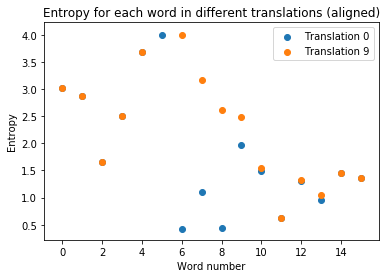

In [11]:
plot_aligned_entropies(0, 9)

Beam-10 vs Greedy translation:

Translation 0:
▁Ich | ▁denke | , | ▁dass | ▁die | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 3:
▁Ich | ▁denke | , | ▁dass | [PLACEHOLDER] | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



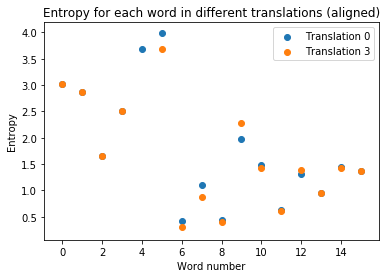

In [12]:
plot_aligned_entropies(0, 3)

Similar translations:

Translation 3:
▁Ich | ▁denke | , | ▁dass | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .
Translation 4:
▁Ich | ▁glaube | , | ▁dass | ▁ | maschine | lle | ▁Übersetzung | ▁ein | ▁sehr | ▁interessante | s | ▁Thema | ▁ist | .



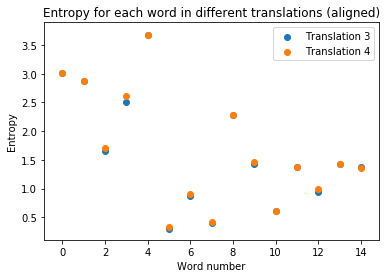

In [13]:
plot_aligned_entropies(3, 4)

In [14]:
other_candidates(9, 0)

Best candidates on position 0 :  ▁Ich ▁Das ▁Die ▁Meiner ▁Meine
Coresponding probabilities: [0.5988918, 0.060954917, 0.036728892, 0.024799734, 0.024179423]


In [152]:
other_candidates(9, 1)

Best candidates on position 1 :  ▁denke ▁glaube ▁halte ▁finde ▁bin
Coresponding probabilities: [0.29839528, 0.25234625, 0.13621552, 0.10573821, 0.043860655]


Zwróćmy też uwagę na niejednoznaczność tokenów: w miejscu, w którym wybieramy token _ prawdopodobieństwo jest małe, oraz entropia duża. Wynika to najprawdopodobniej z tego, że zamiast wybrać token _ , możemy wybrać cały token _ machinelle

### Other probable candidates

In [154]:
other_candidates(3, 1)

Best candidates on position 1 :  ▁denke ▁glaube ▁halte ▁finde ▁bin
Coresponding probabilities: [0.29839528, 0.25234625, 0.13621552, 0.10573821, 0.043860655]


In [153]:
other_candidates(3, 4)

Best candidates on position 4 :  ▁die ▁ ▁das ▁Maschinen ▁eine
Coresponding probabilities: [0.4021218, 0.112477794, 0.079811126, 0.05037697, 0.028617628]


In [155]:
other_candidates(3, 5)

Best candidates on position 5 :  ▁ ▁Übersetzung ▁Maschinen ▁technische ▁Maschinenbau
Coresponding probabilities: [0.4092544, 0.16365328, 0.06526854, 0.013711214, 0.0103740515]


In [156]:
other_candidates(3, 12)

Best candidates on position 12 :  . ▁Thema ▁Themen ▁Gegenstand ▁Subjekt
Coresponding probabilities: [0.45098555, 0.357347, 0.021454206, 0.005650598, 0.0052555017]


In [9]:
other_candidates(0, 5)

Best candidates on position 5 :  lle llen ll ller elle
Coresponding probabilities: [0.89663786, 0.026253838, 0.022556117, 0.012132816, 0.004152786]


In [15]:
other_candidates(0, 0)

Best candidates on position 0 :  ▁Ich ▁Das ▁Die ▁Meiner ▁Meine
Coresponding probabilities: [0.5988918, 0.060954917, 0.036728892, 0.024799734, 0.024179423]


### More difficult sentences:

In [3]:
n_beams = 30
english_sentence = 'Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.'
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.
Top 30 translations:
1. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁ihnen . [p = -11.66]
2. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁ihnen . [p = -11.69]
3. ▁Kinder ▁lieben ▁ihre ▁Eltern ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁sie . [p = -11.72]
4. ▁Kinder ▁beginnen , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁ihnen . [p = -11.73]
5. ▁Kinder ▁beginnen , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁verz eihen ▁sie ▁sie ▁ihnen . [p = -11.83]
6. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁liebe

In [4]:
n_beams = 1
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: Children begin by loving their parents; as they grow older they judge them; sometimes they forgive them.
Top 1 translations:
1. ▁Kinder ▁beginnen ▁damit , ▁ihre ▁Eltern ▁zu ▁lieben ; ▁wenn ▁sie ▁älte r ▁werden , ▁beurteilen ▁sie ▁sie ; ▁ manchmal ▁vergeben ▁sie ▁sie ▁ihnen . [p = -11.85]
Sanity check: log likehood of the best translation = -11.85


In [7]:
n_beams = 30
english_sentence = "There is always something ridiculous about the emotions of people whom one has ceased to love."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: There is always something ridiculous about the emotions of people whom one has ceased to love.
Top 30 translations:
1. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -8.88]
2. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.00]
3. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.06]
4. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.08]
5. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁zu ▁lieben . [p = -9.32]
6. ▁Es ▁gibt ▁immer ▁etwas ▁Lä cherlich es ▁über ▁die ▁Gefühl e ▁von ▁Menschen , ▁die ▁man ▁auf gehört ▁hat ▁zu ▁lieben . [p = -9.35]
7. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich

In [6]:
n_beams = 1
english_sentence = "There is always something ridiculous about the emotions of people whom one has ceased to love."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: There is always something ridiculous about the emotions of people whom one has ceased to love.
Top 1 translations:
1. ▁Es ▁ist ▁immer ▁etwas ▁Lä cherlich es ▁an ▁den ▁Emotion en ▁von ▁Menschen , ▁die ▁man ▁nicht ▁mehr ▁lieben . [p = -9.60]
Sanity check: log likehood of the best translation = -9.60


In [3]:
n_beams = 10
english_sentence = "I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self.
Top 10 translations:
1. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.36]
2. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁er , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.37]
3. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der j en ige , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.54]
4. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et , ▁als ▁den , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.68]
5. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁er , ▁der ▁sei

In [8]:
n_beams = 1
english_sentence = "I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self."
english_tokens = tokenizer.tokenize(english_sentence)
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimizer initialized...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tokens], [translations[0][:-1]])[0]
print(f'Sanity check: log likehood of the best translation = {score:.2f}')

Optimizer initialized...
English sentence: I count him braver who overcomes his desires than him who conquers his enemies; for the hardest victory is over self.
Top 1 translations:
1. ▁Ich ▁z ähle ▁ihn ▁mut iger , ▁der ▁seine ▁Wünsche ▁über wind et ▁als ▁der j en ige , ▁der ▁seine ▁Fein de ▁erobert ; ▁denn ▁der ▁ härte ste ▁Sieg ▁ist ▁über ▁sich ▁selbst . [p = -9.54]
Sanity check: log likehood of the best translation = -9.54


### Continuous optimization

#### Uniform initialization

In [36]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize()
print(res)

Optimization starts...
Score at step  0 = tensor([24.4894], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  59.4
Score at step  2 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  35.64
Score at step  3 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  21.384
Score at step  4 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  12.8304
Score at step  5 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.698239999999999
Score at step  6 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.618943999999999
Score at step  7 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.7713663999999993
Score at step  8 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0

Score at step  67 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.3544686900010173e-13
Score at step  68 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.126812140006103e-14
Score at step  69 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.876087284003662e-14
Score at step  70 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.925652370402197e-14
Score at step  71 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.7553914222413183e-14
Score at step  72 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.053234853344791e-14
Score at step  73 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.319409120068745e-15
Score at step  74 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.791645472041247e-1

Score at step  134 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.853116598174821e-28
Score at step  135 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.1118699589048926e-28
Score at step  136 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.671219753429356e-29
Score at step  137 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.0027318520576135e-29
Score at step  138 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.401639111234568e-29
Score at step  139 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.4409834667407408e-29
Score at step  140 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.645900800444445e-30
Score at step  141 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.187540480

Score at step  200 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.225569715739044e-43
Score at step  201 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.535341829443426e-43
Score at step  202 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.5212050976660558e-43
Score at step  203 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  9.127230585996333e-44
Score at step  204 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.476338351597799e-44
Score at step  205 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.2858030109586797e-44
Score at step  206 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.9714818065752077e-44
Score at step  207 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.182889083

Score at step  266 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  9.635356695934406e-58
Score at step  267 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.7812140175606435e-58
Score at step  268 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.468728410536386e-58
Score at step  269 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.0812370463218313e-58
Score at step  270 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.2487422277930988e-58
Score at step  271 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.492453366758592e-59
Score at step  272 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.495472020055155e-59
Score at step  273 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.697283212

Score at step  331 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.661837531322898e-72
Score at step  332 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.1971025187937385e-72
Score at step  333 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.318261511276243e-72
Score at step  334 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  7.909569067657458e-73
Score at step  335 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.7457414405944743e-73
Score at step  336 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.8474448643566843e-73
Score at step  337 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.7084669186140106e-73
Score at step  338 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.02508015

Score at step  397 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.349906202100137e-87
Score at step  398 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.009943721260082e-87
Score at step  399 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.0059662327560493e-87
Score at step  400 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.8035797396536294e-87
Score at step  401 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.0821478437921776e-87
Score at step  402 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.492887062753065e-88
Score at step  403 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  3.895732237651839e-88
Score at step  404 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.337439342

Score at step  463 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.9039876288198557e-101
Score at step  464 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.1423925772919134e-101
Score at step  465 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  6.8543554637514805e-102
Score at step  466 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  4.1126132782508884e-102
Score at step  467 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  2.467567966950533e-102
Score at step  468 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  1.4805407801703196e-102
Score at step  469 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  8.883244681021917e-103
Score at step  470 = tensor([24.4894], grad_fn=<NegBackward>) max grad component = tensor(0.0002) lr =  5.

#### Greedy initialization with one hot vectors

In [31]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = one_hot_encoder.encode(torch.tensor([[[vocab.stoi[tok] for tok in greedy_translation]]]).transpose(0, 2), v=1000.).squeeze().transpose(0, 1)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init)
print(res)

Optimization starts...
Score at step  0 = tensor([0.4511], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  59.4
Score at step  2 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  35.64
Score at step  3 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  21.384
Score at step  4 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  12.8304
Score at step  5 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.698239999999999
Score at step  6 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.618943999999999
Score at step  7 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.7713663999999993
Score at step  8 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.6628198399999996
S

Score at step  70 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.925652370402197e-14
Score at step  71 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.7553914222413183e-14
Score at step  72 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.053234853344791e-14
Score at step  73 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.319409120068745e-15
Score at step  74 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.791645472041247e-15
Score at step  75 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.2749872832247482e-15
Score at step  76 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.3649923699348489e-15
Score at step  77 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.189954219609093e-16
Score at step  78 = tensor([0

Score at step  138 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.401639111234568e-29
Score at step  139 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.4409834667407408e-29
Score at step  140 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.645900800444445e-30
Score at step  141 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.187540480266667e-30
Score at step  142 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.11252428816e-30
Score at step  143 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.867514572896e-30
Score at step  144 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1205087437376e-30
Score at step  145 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.723052462425599e-31
Score at step  146 = tensor([0.4

Score at step  206 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.9714818065752077e-44
Score at step  207 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1828890839451247e-44
Score at step  208 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.097334503670747e-45
Score at step  209 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.258400702202448e-45
Score at step  210 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.5550404213214687e-45
Score at step  211 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.5330242527928812e-45
Score at step  212 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  9.198145516757287e-46
Score at step  213 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.518887310054372e-46
Score at step  214 =

Score at step  274 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.6183699272198558e-59
Score at step  275 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  9.710219563319135e-60
Score at step  276 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.826131737991481e-60
Score at step  277 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.4956790427948885e-60
Score at step  278 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.097407425676933e-60
Score at step  279 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.2584444554061598e-60
Score at step  280 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.550666732436959e-61
Score at step  281 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.5304000394621755e-61
Score at step  282 =

Score at step  342 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.3285038759142543e-74
Score at step  343 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  7.971023255485526e-75
Score at step  344 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.782613953291315e-75
Score at step  345 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.869568371974789e-75
Score at step  346 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.7217410231848733e-75
Score at step  347 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.033044613910924e-75
Score at step  348 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.198267683465544e-76
Score at step  349 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.718960610079326e-76
Score at step  350 = t

Score at step  410 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.090555699679305e-89
Score at step  411 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.54333419807583e-90
Score at step  412 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.926000518845498e-90
Score at step  413 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.3556003113072986e-90
Score at step  414 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.4133601867843791e-90
Score at step  415 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.480161120706275e-91
Score at step  416 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.088096672423765e-91
Score at step  417 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.0528580034542586e-91
Score at step  418 = t

Score at step  478 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  8.952263938895583e-105
Score at step  479 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  5.37135836333735e-105
Score at step  480 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  3.2228150180024095e-105
Score at step  481 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.9336890108014457e-105
Score at step  482 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  1.1602134064808673e-105
Score at step  483 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  6.961280438885203e-106
Score at step  484 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  4.1767682633311215e-106
Score at step  485 = tensor([0.4511], grad_fn=<NegBackward>) max grad component = tensor(-0.) lr =  2.5060609579986726e-106
Score at ste

In [32]:
print('Greedy translation:', greedy_translation)
print('Continuous translation:', res)
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Continuous translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Score of greedy translation =  tensor([-0.4511])
Score of continuous translation =  tensor([-0.4511])


#### Greedy initialization with probabilities

In [34]:
english_sentence = 'I think, that machine translation is a very interesting subject.'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:15, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init)
print(res)

Optimization starts...
Score at step  0 = tensor([1.8099], grad_fn=<NegBackward>) max grad component =  lr =  99.0
Score at step  1 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.) lr =  98.01
Score at step  2 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  58.806
Score at step  3 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  35.2836
Score at step  4 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  21.17016
Score at step  5 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  12.702096
Score at step  6 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.621257599999999
Score at step  7 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.572754559999999
Score at step  8 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.743

Score at step  68 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.3409240031010065e-13
Score at step  69 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.045544018606039e-14
Score at step  70 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.827326411163623e-14
Score at step  71 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.8963958466981735e-14
Score at step  72 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.737837508018904e-14
Score at step  73 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.0427025048113424e-14
Score at step  74 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.256215028868054e-15
Score at step  75 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.7537290173208325e-15
Scor

Score at step  134 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.0576423869884536e-28
Score at step  135 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.834585432193072e-28
Score at step  136 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.100751259315843e-28
Score at step  137 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.604507555895059e-29
Score at step  138 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.962704533537035e-29
Score at step  139 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.377622720122221e-29
Score at step  140 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.4265736320733325e-29
Score at step  141 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.559441792439995e-3

Score at step  201 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.183314018581651e-43
Score at step  202 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.5099884111489904e-43
Score at step  203 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.5059930466893943e-43
Score at step  204 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  9.035958280136365e-44
Score at step  205 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.421574968081819e-44
Score at step  206 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.2529449808490915e-44
Score at step  207 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.9517669885094548e-44
Score at step  208 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.1710601931056727

Score at step  267 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  9.539003128975051e-58
Score at step  268 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.72340187738503e-58
Score at step  269 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.434041126431018e-58
Score at step  270 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.060424675858611e-58
Score at step  271 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.2362548055151665e-58
Score at step  272 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.417528833090999e-59
Score at step  273 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.450517299854599e-59
Score at step  274 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.670310379912759e-59


Score at step  334 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.305078896163479e-72
Score at step  335 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  7.830473376980874e-73
Score at step  336 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.698284026188524e-73
Score at step  337 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.8189704157131146e-73
Score at step  338 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.6913822494278687e-73
Score at step  339 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.0148293496567212e-73
Score at step  340 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.088976097940327e-74
Score at step  341 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.653385658764196e-

Score at step  401 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.7855439422570933e-87
Score at step  402 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.071326365354256e-87
Score at step  403 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  6.427958192125536e-88
Score at step  404 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.8567749152753214e-88
Score at step  405 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.3140649491651927e-88
Score at step  406 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.3884389694991155e-88
Score at step  407 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.330633816994693e-89
Score at step  408 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.998380290196815e

Score at step  467 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  4.0714871454683796e-102
Score at step  468 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  2.4428922872810275e-102
Score at step  469 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.4657353723686165e-102
Score at step  470 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  8.794412234211698e-103
Score at step  471 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  5.276647340527019e-103
Score at step  472 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  3.1659884043162114e-103
Score at step  473 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.8995930425897267e-103
Score at step  474 = tensor([1.1511], grad_fn=<NegBackward>) max grad component = tensor(0.0047) lr =  1.13975582

In [35]:
print('Greedy translation:', greedy_translation)
print('Continuous translation:', res)
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ['▁Ich', '▁denke', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist', '.']
Continuous translation: ['▁Ich', '▁halte', ',', '▁dass', '▁die', '▁', 'maschine', 'lle', '▁Übersetzung', '▁ein', '▁sehr', '▁interessante', 's', '▁Thema', '▁ist']
Score of greedy translation =  tensor([-0.4511])
Score of continuous translation =  tensor([-1.6082])


#### Sentence from test set

In [3]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='multiplication', verbose=True)
print(res)

Optimization starts...
Step 0 , loss score =  tensor([2.3881], grad_fn=<NegBackward>) max grad component =  lr =  100
	 cscore =  tensor([2.3881], grad_fn=<NegBackward>)
	dscore =  tensor([0.5355])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 1 , loss score =  tensor([1.9038], grad_fn=<NegBackward>) max grad component = 0.0 lr =  100
	 cscore =  tensor([1.9038], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 2 , loss score =  tensor([1.6958], grad_fn=<NegBackward>) max grad component = 0.0 lr =  100
	 cscore =  tensor([1.6958], grad_fn=<NegBackward>)
	dscore =  tensor([0.5412])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁will , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁en

Step 24 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.01220703125
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 25 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.006103515625
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 26 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  0.0030517578125
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁d

	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 47 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  1.4551915228366852e-09
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 48 , loss score =  tensor([1.5815], grad_fn=<NegBackward>) max grad component = 0.0013183180708438158 lr =  7.275957614183426e-10
	 cscore =  tensor([1.5838], grad_fn=<NegBackward>)
	dscore =  tensor([0.5352])
▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "

Step 49 , loss score =  

In [4]:
print('Greedy translation:', ' '.join(greedy_translation))
print('Continuous translation:', ' '.join(res))
print('Score of greedy translation = ' , -scorer.score_tokenized_texts([english_tok], [greedy_translation], method='multiplication', normalize=True))
print('Score of continuous translation = ', -scorer.score_tokenized_texts([english_tok], [res], method='multiplication', normalize=True))

Greedy translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Continuous translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Score of greedy translation =  tensor([0.5355])
Score of continuous translation =  tensor([0.5352])


In [55]:
print('BLEU of greedy: 11.06')
print('BLEU of continuous: 9.67')
print('(measured by multi-bleu.perl script)')

BLEU of greedy: 11.06
BLEU of continuous: 9.67
(measured by multi-bleu.perl script)


In [60]:
n_beams = 10
optimizer = BeamOptimizer(english_sentence, n_beams=n_beams)
print('Optimization starts...')
translations, probabilities = optimizer.optimize()
print('English sentence:', english_sentence)
print('Top', n_beams, 'translations:')
for i, translation in enumerate(translations):
    print(f"{i+1}. {' '.join(translation[:-1])} [p = {probabilities[i]:.2f}]")

score = scorer.score_tokenized_texts([english_tok], [translations[0][:-1]])[0]
print(f'Sanity check: score of the best translation = {score:.2f}')

Optimization starts...
English sentence: But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."
Top 10 translations:
1. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁indem ▁er ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.19]
2. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁wenn ▁er ▁sagte : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.32]
3. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁wenn ▁er ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . " [p = -20.34]
4. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jemand en ▁denken , ▁der ▁ihm ▁we h ▁tun ▁würde , ▁indem ▁er ▁sagt : ▁" Es ▁geht ▁ihm ▁endlich ▁gut . " [p = -20.59]
5. ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁nicht ▁an ▁jem

In [61]:
print('BLEU of beam: 12.98')

BLEU of beam: 12.98


In [ ]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='cross_entropy', verbose=True)
print(res)

### Continuous with cross entropy

In [3]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
greedy_optimizer = GreedyOptimizer(english_sentence)
greedy_translation = greedy_optimizer.optimize()[:-1]
greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
greedy_init = torch.tensor(greedy_init[:-1, :].T)

optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(init=greedy_init, method='multiplication')
print(res)

KeyboardInterrupt: 

In [5]:
print('Greedy translation:', ' '.join(greedy_translation))
print('Continuous translation:', ' '.join(res))
print('Score of greedy translation = ' , scorer.score_tokenized_texts([english_tok], [greedy_translation]))
print('Score of continuous translation = ', scorer.score_tokenized_texts([english_tok], [res]))

Greedy translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagt , ▁er ▁könne ▁niemand en ▁denken , ▁der ▁ihn ▁verletz en ▁würde , ▁und ▁sagt : ▁" Es ▁ging ▁ihm ▁endlich ▁gut . "
Continuous translation: ▁Aber ▁der ▁Bruder ▁des ▁Opfer s ▁sagte , ▁er ▁könne ▁nicht en ▁denken , ▁der ▁ihn ▁verletz en ▁möchte , ▁und ▁sagte : ▁„ Es ▁ging ▁ihm ▁endlich ▁gut . "
Score of greedy translation =  tensor([-0.5355])
Score of continuous translation =  tensor([-1.0102])


In [6]:
print('BLEU of continuous translation with cross entropy: 13.46')

BLEU of continuous translation with cross entropy: 13.46


#### Continuous optimization with cross entropy - uniform initialization

In [11]:
english_sentence = 'But the victim\'s brother says he can\'t think of anyone who would want to hurt him, saying, "Things were finally going well for him."'
english_tok = tokenizer.tokenize(english_sentence)
optimizer = ContinuousOptimizer(english_sentence)
print('Optimization starts...')
res = optimizer.optimize(method='multiplication', verbose=True)
print(res)

Optimization starts...
0
Step 0 , loss score =  tensor([24.9637], grad_fn=<NegBackward>) max grad component =  lr =  50
	 cscore =  tensor([24.9637], grad_fn=<NegBackward>)


AssertionError: Dataset cannot contain Special Tokens

In [64]:
def plot_aligned_entropies(trans_i, trans_j):
    plt.title('Entropy for each word in different translations (aligned)')
    plt.xlabel('Word number')
    plt.ylabel('Entropy')
    
    aligner = Aligner()
    aligned_i, aligned_j = aligner.align(trans_i, trans_j)
    
    logprobs_i = scorer.score_probabilities_for_each_word(english_tok, trans_i)
    probs_i = np.exp(logprobs_i)
    logprobs_j = scorer.score_probabilities_for_each_word(english_tok, trans_j)
    probs_j = np.exp(logprobs_j)

    words = np.arange(len(aligned_i))
    entropies_i = []
    k = 0
    for word in aligned_i:
        if word == '[PLACEHOLDER]':
            entropies_i += [-1.]
        else:
            entropies_i += [entropy(probs_i[k, :])]
            k += 1
    entropies_i = np.array(entropies_i)
    
    entropies_j = []
    k = 0
    for word in aligned_j:
        if word == '[PLACEHOLDER]':
            entropies_j += [-1.]
        else:
            entropies_j += [entropy(probs_j[k, :])]
            k += 1
    entropies_j = np.array(entropies_j)
    
    plt.scatter(words[entropies_i >= 0.], entropies_i[entropies_i >= 0.], label=f'Translation 1')
    plt.scatter(words[entropies_j >= 0.], entropies_j[entropies_j >= 0.], label=f'Translation 2')
    print(f'Translation 1:\n{" | ".join(aligned_i)}')
    print(f'Translation 2:\n{" | ".join(aligned_j)}')
    print()
    plt.legend()

Translation 1:
▁Aber | ▁der | ▁Bruder | ▁des | ▁Opfer | s | ▁sagt | , | ▁er | ▁könne | ▁nicht | ▁an | ▁jemand | en | ▁denken | , | ▁der | ▁ihm | ▁we | h | ▁tun | ▁würde | , | ▁indem | ▁er | ▁sagt | : | ▁" | Es | ▁ging | ▁ihm | ▁endlich | ▁gut | . | "
Translation 2:
▁Aber | ▁der | ▁Bruder | ▁des | ▁Opfer | s | ▁sagt | , | ▁er | ▁könne | [PLACEHOLDER] | [PLACEHOLDER] | ▁niemand | en | ▁denken | , | ▁der | [PLACEHOLDER] | ▁ihn | ▁verletz | en | ▁würde | , | [PLACEHOLDER] | ▁und | ▁sagt | : | ▁" | Es | ▁ging | ▁ihm | ▁endlich | ▁gut | . | "



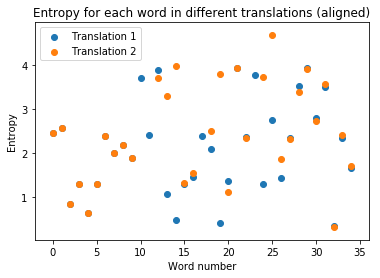

In [66]:
plot_aligned_entropies(translations[0][:-1], greedy_translation, )

### Continuous with multiplication - more examples

In [5]:
WMT_DIR = '/home/pma/wmt/'
german_path = WMT_DIR + 'test.de'
english_path = WMT_DIR + 'test.en'

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

def load_test_data(path):
    with open(path) as f:
        return [tokenizer.detokenize(line.split()) for line in f.readlines()]

def load_reference_data(path):
    with open(path) as f:
        return [line.strip() for line in f.readlines()]
    
def perform_tests(k=50, initialization='greedy', beamsize=15, temperature=1., optimizer='sgd', start_lr=100.):
    aligner = Aligner()
    scorer = Scorer(temperature=temperature)
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)
    
    greedy_dscores = []
    greedy_bleus = []
    cont_dscores = []
    cont_bleus = []
    
    failed_cnt = 0
    better_score_cnt = 0
    no_change_score_cnt = 0
    worse_score_cnt = 0
    better_bleu_cnt = 0
    no_change_bleu_cnt = 0
    worse_bleu_cnt = 0
    bleu_before_sum = 0
    bleu_after_sum = 0
    score_before_sum = 0
    score_after_sum = 0
    i = 0
    for english_sentence, reference in zip(english_sentences[:k], references):
        i += 1
        print('Sentence', i)
        print(english_sentence)
        english_tok = tokenizer.tokenize(english_sentence)
        if initialization == 'greedy':
            greedy_optimizer = GreedyOptimizer(english_sentence, temperature=temperature)
            greedy_translation = greedy_optimizer.optimize()[:-1]
        else:
            greedy_optimizer = BeamOptimizer(english_sentence, beamsize, temperature=temperature)
            greedy_translation = greedy_optimizer.optimize()[0][0][:-1]
        
        greedy_score = -scorer.score_tokenized_texts([english_tok], [greedy_translation], method='multiplication', normalize=True)
        gbleu = bleu(reference, ' '.join(greedy_translation))

        greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
        greedy_init = torch.tensor(greedy_init[:-1, :].T)
        maxes = torch.max(greedy_init, 0)[0]
        
        if optimizer == 'sgd':
            continuous_optimizer = ContinuousOptimizer(english_sentence, temperature=temperature)
        else:
            continuous_optimizer = ExponentiatedGradientOptimizer(english_sentence, temperature=temperature)
        
        try:
            continuous_translation, cscore = continuous_optimizer.optimize(init=greedy_init, method='multiplication', with_score=True, start_lr=start_lr)
            dscore = -scorer.score_tokenized_texts([english_tok], [continuous_translation], method='multiplication', normalize=True)
            cbleu = bleu(reference, ' '.join(continuous_translation))
        except AssertionError:
            failed_cnt += 1
            continue 
            

        aligned_greedy, aligned_continuous = aligner.align(greedy_translation, continuous_translation)
        
        colored_continuous = [cstr(cword, color='black') if gword == cword else cstr(cword, color='green') 
            for gword, cword in zip(aligned_greedy, aligned_continuous)]
        colored_continuous.append(cstr(f'[ cscore={cscore.item()}, dscore={dscore.item()}, bleu={cbleu} ]', color='black'))
        
        display(html_print(cstr(' '.join(aligned_greedy) + f'[ dscore={greedy_score.item()}, bleu={gbleu} ]', color='black')))
        display(html_print(' '.join(colored_continuous)))
        display(html_print('<br>'))
        
        if dscore < greedy_score:
            better_score_cnt += 1
        if dscore == greedy_score:
            no_change_score_cnt += 1
        if dscore > greedy_score:
            worse_score_cnt += 1
        
        if cbleu > gbleu:
            better_bleu_cnt += 1
        if cbleu == gbleu:
            no_change_bleu_cnt += 1
        if cbleu < gbleu:
            worse_bleu_cnt += 1
            
        bleu_before_sum += gbleu
        bleu_after_sum += cbleu
        score_before_sum += greedy_score
        score_after_sum += dscore
        
        greedy_dscores += [greedy_score]
        greedy_bleus += [gbleu]
        cont_dscores += [dscore]
        cont_bleus += [cbleu]
        
        
    
    better_score_percent = 100 * better_score_cnt / float(k)
    no_change_score_percent = 100 * no_change_score_cnt / float(k)
    worse_score_percent = 100 * worse_score_cnt / float(k)
    better_bleu_percent = 100 * better_bleu_cnt / float(k)
    no_change_bleu_percent = 100 * no_change_bleu_cnt / float(k)
    worse_bleu_percent = 100 * worse_bleu_cnt / float(k)
    avg_bleu_before = bleu_before_sum / float(k)
    avg_bleu_after = bleu_after_sum / float(k)
    avg_dscore_before = score_before_sum.item() / float(k)
    avg_dscore_after = score_after_sum.item() / float(k)
    
    print(f'Total statistics (tested on {k} sentences)')
    print(f'{failed_cnt} sentences st. continuous optimization failed')
    print(f'{better_score_cnt} sentences with better score ({better_score_percent}%)')
    print(f'{no_change_score_cnt} sentences without change in score ({no_change_score_percent}%)')
    print(f'{worse_score_cnt} sentences with worse score ({worse_score_percent}%)')
    print(f'{better_bleu_cnt} sentences with better bleu ({better_bleu_percent}%)')
    print(f'{no_change_bleu_cnt} sentences without change in bleu ({no_change_bleu_percent}%)')
    print(f'{worse_bleu_percent} sentences with worse bleu ({worse_bleu_percent}%)')
    print(f'Average BLEU before continuous optimization: {avg_bleu_before}')
    print(f'Average BLEU after continuous optimization: {avg_bleu_after}')
    print(f'Average dscore before continuous optimization: {avg_dscore_before}')
    print(f'Average dscore after continuous optimization: {avg_dscore_after}')
    
    return greedy_dscores, greedy_bleus, cont_dscores, cont_bleus

def compare_beam_greedy(k, n_beams=10, return_aligned=True):
    aligner = Aligner()
    scorer = Scorer()
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)
    english_sentence = english_sentences[k]
    print(english_sentence)
    english_tok = tokenizer.tokenize(english_sentence)
    reference = references[k]
    greedy_optimizer = GreedyOptimizer(english_sentence)
    greedy_translation = greedy_optimizer.optimize()[:-1]
    
    greedy_score = -scorer.score_tokenized_texts([english_tok], [greedy_translation])
    gbleu = bleu(reference, ' '.join(greedy_translation))
    
    display(html_print(cstr('Greedy: ' + ' '.join(greedy_translation), color='black')))
    display(html_print(cstr(f'greedy dscore = {greedy_score}, greedy bleu = {gbleu}', color='black')))
    display(html_print('<br>'))


    beam_optimizer = BeamOptimizer(english_sentence, n_beams = n_beams)
    beam_translations = beam_optimizer.optimize()
    beam_translation = beam_translations[0][0][:-1]
    display(html_print(cstr('Beam: ' + ' '.join(beam_translation), color='black')))
    beam_score = -scorer.score_tokenized_texts([english_tok], [beam_translation])
    bbleu = bleu(reference, ' '.join(beam_translation))
    
    greedy_translation_aligned, beam_translation_aligned = aligner.align(greedy_translation, beam_translation)
    colored_translation = [cstr(gword, color='black') if gword == bword else cstr(bword, color='green') 
        for gword, bword in zip(greedy_translation_aligned, beam_translation_aligned)] 
    
    display(html_print(cstr(f'beam dscore = {beam_score}, beam bleu = {bbleu}', color='black')))
    display(html_print(' '.join(colored_translation)))
    display(html_print('<br>'))
    
    greedy_logprobs = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
    greedy_probs = np.exp(greedy_logprobs)
    beam_logprobs = scorer.score_probabilities_for_each_word(english_tok, beam_translation)
    beam_probs = np.exp(beam_logprobs)
    if return_aligned:
        return greedy_translation_aligned, greedy_probs, beam_translation_aligned, beam_probs
    else:
        return greedy_translation, greedy_probs, beam_translation, beam_probs

def plot_entropies(greedy_translation_aligned, greedy_probs, beam_translation_aligned, beam_probs):
    words = np.arange(len(greedy_translation_aligned))
    greedy_entropies = []
    k = 0
    for word in greedy_translation_aligned:
        if word == '[PLACEHOLDER]':
            greedy_entropies += [-1.]
        else:
            greedy_entropies += [entropy(greedy_probs[k, :])]
            k += 1
    greedy_entropies = np.array(greedy_entropies)
    
    beam_entropies = []
    k = 0
    for word in beam_translation_aligned:
        if word == '[PLACEHOLDER]':
            beam_entropies += [-1.]
        else:
            beam_entropies += [entropy(beam_probs[k, :])]
            k += 1
    beam_entropies = np.array(beam_entropies)
    
    gta_arr = np.array(greedy_translation_aligned)
    bta_arr = np.array(beam_translation_aligned)
    plt.scatter(words[greedy_entropies >= 0.], greedy_entropies[greedy_entropies >= 0.], label=f'Greedy search')
    plt.scatter(words[beam_entropies >= 0.], beam_entropies[beam_entropies >= 0.], label=f'Beam search')    
    

def other_candidates(sentence_idx, translation, pos, N = 5):
    scorer = Scorer()
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)
    english_sentence = english_sentences[sentence_idx]
    print(english_sentence)
    english_tokens = tokenizer.tokenize(english_sentence)
    print(' '.join(translation))
    
    logprobs = scorer.score_probabilities_for_each_word(english_tokens, translation)
    probs = np.exp(logprobs)
    other_good_choices = np.argsort(probs[pos])[:-6:-1]
    print('Best candidates on position', pos, ': ', ' '.join([vocab.itos[idx] for idx in other_good_choices]))
    print('Coresponding probabilities:', [probs[pos][idx] for idx in other_good_choices])  
    return probs
    
def perform_detailed_test(k, initialization='greedy', temperature=1.0):
    aligner = Aligner()
    scorer = Scorer(temperature=temperature)
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)
    english_sentence = english_sentences[k]
    print(english_sentence)
    english_tok = tokenizer.tokenize(english_sentence)
    reference = references[k]
    greedy_optimizer = GreedyOptimizer(english_sentence, temperature=temperature)
    greedy_translation = greedy_optimizer.optimize()[:-1]
    
    greedy_score = -scorer.score_tokenized_texts([english_tok], [greedy_translation], method='multiplication', normalize=True)
    gbleu = bleu(reference, ' '.join(greedy_translation))
    
    display(html_print(cstr('Greedy: ' + ' '.join(greedy_translation), color='black')))
    display(html_print(cstr(f'greedy dscore = {greedy_score}, greedy bleu = {gbleu}', color='black')))
    display(html_print('<br>'))
    display(html_print(cstr('Optimization trace:')))

    greedy_init = scorer.score_probabilities_for_each_word(english_tok, greedy_translation)
    greedy_init = torch.tensor(greedy_init[:-1, :].T)
    continuous_optimizer = ContinuousOptimizer(english_sentence, temperature=temperature)
    trace = continuous_optimizer.optimize_with_trace(init=greedy_init, method='multiplication', start_lr=100)
    prev_translation = None
    prev_dscore = None
    for trace_entry in trace:
        display(html_print(cstr(f'Step {trace_entry["step"]}', color='black')))
        loss_score = trace_entry["loss_score"].item()
        cscore = trace_entry["cscore"].item()
        dscore = trace_entry["dscore"].item()
        if prev_dscore is None or prev_dscore >= dscore:
            display(html_print(cstr(f'\tloss_score = {loss_score}, cscore = {cscore}, dscore = {dscore}', color='black')))
        else:
            display(html_print(cstr(f'\tloss_score = {loss_score}, cscore = {cscore}, ', color='black') + cstr(f'dscore = {dscore}', color='red')))
        prev_dscore = dscore
        
        translation = trace_entry['translation']
        if prev_translation is None:
            display(html_print(cstr('\t' + ' '.join(translation), color='black')))
        else:
            prev_translation_aligned, translation_aligned = aligner.align(prev_translation, translation)
            colored_translation = [cstr(cword, color='black') if pword == cword else cstr(cword, color='green') 
                for pword, cword in zip(prev_translation_aligned, translation_aligned)] 
            
            display(html_print(' '.join(colored_translation)))
            display(html_print('<br>'))
        prev_translation = translation
    return trace

def plot_costs(trace, output):
    plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
    })
    steps = np.arange(1, len(trace)+1)
    cscores = np.array([e['cscore'].item() for e in trace])
    dscores = np.array([e['dscore'].item() for e in trace])
    plt.figure()
    plt.plot(steps, cscores, label='continuous cost')
    plt.plot(steps, dscores, label='discrete cost')
    plt.title('Continuous and discrete costs during the optimization process')
    plt.xlabel('step')
    plt.ylabel('cost')
    plt.legend()
    plt.savefig(output)
    plt.show()


In [6]:
res = perform_tests(k=100, initialization='greedy', temperature=1.)

28-Year-Old Chef Found Dead at San Francisco Mall


A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.


KeyboardInterrupt: 

In [4]:
perform_tests(k=100, initialization='greedy', temperature=100)

torch.Size([31538, 9])
tensor([[-10.3585, -10.3548, -10.3522,  ..., -10.3516, -10.3542, -10.3493],
        [-10.5698, -10.6717, -10.6369,  ..., -10.6855, -10.6915, -10.7206],
        [-10.3585, -10.3548, -10.3522,  ..., -10.3516, -10.3542, -10.3493],
        ...,
        [-10.3586, -10.3547, -10.3522,  ..., -10.3516, -10.3542, -10.3494],
        [-10.3585, -10.3548, -10.3522,  ..., -10.3516, -10.3542, -10.3493],
        [-10.3588, -10.3549, -10.3524,  ..., -10.3517, -10.3543, -10.3498]])


torch.Size([31538, 34])
tensor([[-10.3602, -10.3562, -10.3565,  ..., -10.3538, -10.3522, -10.3583],
        [-10.5470, -10.5848, -10.6072,  ..., -10.6843, -10.7047, -10.5790],
        [-10.3602, -10.3562, -10.3565,  ..., -10.3538, -10.3522, -10.3583],
        ...,
        [-10.3602, -10.3561, -10.3564,  ..., -10.3537, -10.3522, -10.3584],
        [-10.3602, -10.3562, -10.3565,  ..., -10.3538, -10.3522, -10.3583],
        [-10.3604, -10.3563, -10.3564,  ..., -10.3535, -10.3523, -10.3584]])


torch.Size([31538, 31])
tensor([[-10.3584, -10.3566, -10.3532,  ..., -10.3551, -10.3553, -10.3566],
        [-10.5471, -10.6096, -10.6120,  ..., -10.6210, -10.6301, -10.6220],
        [-10.3584, -10.3566, -10.3532,  ..., -10.3551, -10.3553, -10.3566],
        ...,
        [-10.3584, -10.3566, -10.3532,  ..., -10.3550, -10.3553, -10.3566],
        [-10.3584, -10.3566, -10.3532,  ..., -10.3551, -10.3553, -10.3566],
        [-10.3585, -10.3566, -10.3534,  ..., -10.3551, -10.3553, -10.3567]])


torch.Size([31538, 38])
tensor([[-10.3618, -10.3598, -10.3559,  ..., -10.3584, -10.3542, -10.3571],
        [-10.5397, -10.5758, -10.6319,  ..., -10.5649, -10.5856, -10.6564],
        [-10.3618, -10.3598, -10.3559,  ..., -10.3584, -10.3542, -10.3571],
        ...,
        [-10.3618, -10.3597, -10.3558,  ..., -10.3584, -10.3541, -10.3570],
        [-10.3618, -10.3598, -10.3559,  ..., -10.3584, -10.3542, -10.3571],
        [-10.3618, -10.3597, -10.3558,  ..., -10.3584, -10.3540, -10.3571]])


torch.Size([31538, 24])
tensor([[-10.3608, -10.3572, -10.3564,  ..., -10.3564, -10.3524, -10.3579],
        [-10.5538, -10.5841, -10.5990,  ..., -10.5801, -10.6181, -10.5907],
        [-10.3608, -10.3572, -10.3564,  ..., -10.3564, -10.3524, -10.3579],
        ...,
        [-10.3608, -10.3572, -10.3563,  ..., -10.3563, -10.3522, -10.3579],
        [-10.3608, -10.3572, -10.3564,  ..., -10.3564, -10.3524, -10.3579],
        [-10.3609, -10.3572, -10.3563,  ..., -10.3561, -10.3519, -10.3578]])


torch.Size([31538, 59])
tensor([[-10.3586, -10.3540, -10.3565,  ..., -10.3556, -10.3566, -10.3581],
        [-10.5730, -10.6218, -10.5746,  ..., -10.5912, -10.5562, -10.5789],
        [-10.3586, -10.3540, -10.3565,  ..., -10.3556, -10.3566, -10.3581],
        ...,
        [-10.3586, -10.3541, -10.3565,  ..., -10.3556, -10.3566, -10.3582],
        [-10.3586, -10.3540, -10.3565,  ..., -10.3556, -10.3566, -10.3581],
        [-10.3584, -10.3543, -10.3564,  ..., -10.3551, -10.3566, -10.3582]])


torch.Size([31538, 25])
tensor([[-10.3605, -10.3554, -10.3572,  ..., -10.3571, -10.3579, -10.3583],
        [-10.5478, -10.5939, -10.5280,  ..., -10.5798, -10.5472, -10.5836],
        [-10.3605, -10.3554, -10.3572,  ..., -10.3571, -10.3579, -10.3583],
        ...,
        [-10.3605, -10.3553, -10.3571,  ..., -10.3570, -10.3578, -10.3583],
        [-10.3605, -10.3554, -10.3572,  ..., -10.3571, -10.3579, -10.3583],
        [-10.3606, -10.3553, -10.3571,  ..., -10.3570, -10.3578, -10.3583]])


torch.Size([31538, 29])
tensor([[-10.3611, -10.3574, -10.3575,  ..., -10.3537, -10.3570, -10.3572],
        [-10.5498, -10.5996, -10.5334,  ..., -10.5913, -10.5448, -10.6093],
        [-10.3611, -10.3574, -10.3575,  ..., -10.3537, -10.3570, -10.3572],
        ...,
        [-10.3611, -10.3575, -10.3576,  ..., -10.3536, -10.3569, -10.3571],
        [-10.3611, -10.3574, -10.3575,  ..., -10.3537, -10.3570, -10.3572],
        [-10.3612, -10.3575, -10.3576,  ..., -10.3537, -10.3569, -10.3572]])


torch.Size([31538, 19])
tensor([[-10.3598, -10.3568, -10.3584,  ..., -10.3588, -10.3557, -10.3581],
        [-10.5501, -10.6127, -10.5482,  ..., -10.5357, -10.5838, -10.5608],
        [-10.3598, -10.3568, -10.3584,  ..., -10.3588, -10.3557, -10.3581],
        ...,
        [-10.3598, -10.3568, -10.3585,  ..., -10.3588, -10.3558, -10.3581],
        [-10.3598, -10.3568, -10.3584,  ..., -10.3588, -10.3557, -10.3581],
        [-10.3597, -10.3568, -10.3584,  ..., -10.3588, -10.3559, -10.3580]])


torch.Size([31538, 27])
tensor([[-10.3546, -10.3485, -10.3558,  ..., -10.3548, -10.3564, -10.3566],
        [-10.5876, -10.6113, -10.6321,  ..., -10.6081, -10.5853, -10.5982],
        [-10.3546, -10.3485, -10.3558,  ..., -10.3548, -10.3564, -10.3566],
        ...,
        [-10.3546, -10.3485, -10.3558,  ..., -10.3548, -10.3564, -10.3566],
        [-10.3546, -10.3485, -10.3558,  ..., -10.3548, -10.3564, -10.3566],
        [-10.3546, -10.3488, -10.3560,  ..., -10.3549, -10.3564, -10.3566]])


torch.Size([31538, 20])
tensor([[-10.3600, -10.3561, -10.3568,  ..., -10.3565, -10.3536, -10.3572],
        [-10.5530, -10.5951, -10.5909,  ..., -10.6289, -10.5644, -10.6232],
        [-10.3600, -10.3561, -10.3568,  ..., -10.3565, -10.3536, -10.3572],
        ...,
        [-10.3600, -10.3563, -10.3567,  ..., -10.3565, -10.3536, -10.3572],
        [-10.3600, -10.3561, -10.3568,  ..., -10.3565, -10.3536, -10.3572],
        [-10.3601, -10.3564, -10.3567,  ..., -10.3567, -10.3537, -10.3572]])


torch.Size([31538, 20])
tensor([[-10.3573, -10.3489, -10.3562,  ..., -10.3589, -10.3567, -10.3583],
        [-10.5662, -10.6258, -10.6254,  ..., -10.5269, -10.5937, -10.5700],
        [-10.3573, -10.3489, -10.3562,  ..., -10.3589, -10.3567, -10.3583],
        ...,
        [-10.3573, -10.3490, -10.3563,  ..., -10.3589, -10.3568, -10.3584],
        [-10.3573, -10.3489, -10.3562,  ..., -10.3589, -10.3567, -10.3583],
        [-10.3573, -10.3492, -10.3564,  ..., -10.3588, -10.3566, -10.3583]])


torch.Size([31538, 11])
tensor([[-10.3609, -10.3579, -10.3577,  ..., -10.3552, -10.3543, -10.3578],
        [-10.5460, -10.5478, -10.5833,  ..., -10.5798, -10.6063, -10.5923],
        [-10.3609, -10.3579, -10.3577,  ..., -10.3552, -10.3543, -10.3578],
        ...,
        [-10.3609, -10.3580, -10.3577,  ..., -10.3552, -10.3544, -10.3578],
        [-10.3609, -10.3579, -10.3577,  ..., -10.3552, -10.3543, -10.3578],
        [-10.3610, -10.3580, -10.3579,  ..., -10.3553, -10.3543, -10.3578]])


torch.Size([31538, 23])
tensor([[-10.3595, -10.3572, -10.3575,  ..., -10.3499, -10.3570, -10.3577],
        [-10.5431, -10.5873, -10.5847,  ..., -10.6242, -10.5956, -10.5990],
        [-10.3595, -10.3572, -10.3575,  ..., -10.3499, -10.3570, -10.3577],
        ...,
        [-10.3595, -10.3572, -10.3574,  ..., -10.3499, -10.3570, -10.3577],
        [-10.3595, -10.3572, -10.3575,  ..., -10.3499, -10.3570, -10.3577],
        [-10.3595, -10.3573, -10.3573,  ..., -10.3502, -10.3570, -10.3577]])


torch.Size([31538, 15])
tensor([[-10.3599, -10.3578, -10.3580,  ..., -10.3560, -10.3563, -10.3589],
        [-10.5563, -10.5521, -10.5548,  ..., -10.6240, -10.6282, -10.5565],
        [-10.3599, -10.3578, -10.3580,  ..., -10.3560, -10.3563, -10.3589],
        ...,
        [-10.3599, -10.3579, -10.3580,  ..., -10.3559, -10.3564, -10.3589],
        [-10.3599, -10.3578, -10.3580,  ..., -10.3560, -10.3563, -10.3589],
        [-10.3600, -10.3578, -10.3580,  ..., -10.3561, -10.3562, -10.3590]])


torch.Size([31538, 11])
tensor([[-10.3600, -10.3573, -10.3572,  ..., -10.3549, -10.3563, -10.3583],
        [-10.5592, -10.5599, -10.5984,  ..., -10.5812, -10.6525, -10.5936],
        [-10.3600, -10.3573, -10.3572,  ..., -10.3549, -10.3563, -10.3583],
        ...,
        [-10.3600, -10.3573, -10.3572,  ..., -10.3549, -10.3563, -10.3583],
        [-10.3600, -10.3573, -10.3572,  ..., -10.3549, -10.3563, -10.3583],
        [-10.3601, -10.3574, -10.3573,  ..., -10.3551, -10.3563, -10.3583]])


torch.Size([31538, 31])
tensor([[-10.3603, -10.3557, -10.3578,  ..., -10.3560, -10.3573, -10.3573],
        [-10.5579, -10.6235, -10.5492,  ..., -10.6516, -10.6287, -10.5980],
        [-10.3603, -10.3557, -10.3578,  ..., -10.3560, -10.3573, -10.3573],
        ...,
        [-10.3604, -10.3558, -10.3578,  ..., -10.3560, -10.3573, -10.3573],
        [-10.3603, -10.3557, -10.3578,  ..., -10.3560, -10.3573, -10.3573],
        [-10.3605, -10.3559, -10.3580,  ..., -10.3560, -10.3574, -10.3575]])


torch.Size([31538, 30])
tensor([[-10.3597, -10.3568, -10.3566,  ..., -10.3554, -10.3544, -10.3584],
        [-10.5373, -10.5967, -10.6109,  ..., -10.6380, -10.5702, -10.5826],
        [-10.3597, -10.3568, -10.3566,  ..., -10.3554, -10.3544, -10.3584],
        ...,
        [-10.3597, -10.3567, -10.3565,  ..., -10.3553, -10.3543, -10.3584],
        [-10.3597, -10.3568, -10.3566,  ..., -10.3554, -10.3544, -10.3584],
        [-10.3598, -10.3568, -10.3564,  ..., -10.3553, -10.3542, -10.3584]])


torch.Size([31538, 21])
tensor([[-10.3598, -10.3586, -10.3563,  ..., -10.3520, -10.3577, -10.3578],
        [-10.5684, -10.5672, -10.5596,  ..., -10.6140, -10.5620, -10.6030],
        [-10.3598, -10.3586, -10.3563,  ..., -10.3520, -10.3577, -10.3578],
        ...,
        [-10.3599, -10.3586, -10.3564,  ..., -10.3522, -10.3577, -10.3579],
        [-10.3598, -10.3586, -10.3563,  ..., -10.3520, -10.3577, -10.3578],
        [-10.3600, -10.3586, -10.3563,  ..., -10.3520, -10.3576, -10.3579]])


torch.Size([31538, 15])
tensor([[-10.3594, -10.3588, -10.3561,  ..., -10.3564, -10.3569, -10.3586],
        [-10.5550, -10.5511, -10.5381,  ..., -10.6066, -10.5828, -10.5741],
        [-10.3594, -10.3588, -10.3561,  ..., -10.3564, -10.3569, -10.3586],
        ...,
        [-10.3595, -10.3588, -10.3562,  ..., -10.3564, -10.3569, -10.3586],
        [-10.3594, -10.3588, -10.3561,  ..., -10.3564, -10.3569, -10.3586],
        [-10.3596, -10.3587, -10.3561,  ..., -10.3561, -10.3569, -10.3586]])


torch.Size([31538, 14])
tensor([[-10.3585, -10.3569, -10.3573,  ..., -10.3552, -10.3563, -10.3584],
        [-10.5502, -10.5759, -10.5898,  ..., -10.6106, -10.5826, -10.5606],
        [-10.3585, -10.3569, -10.3573,  ..., -10.3552, -10.3563, -10.3584],
        ...,
        [-10.3586, -10.3569, -10.3573,  ..., -10.3551, -10.3563, -10.3584],
        [-10.3585, -10.3569, -10.3573,  ..., -10.3552, -10.3563, -10.3584],
        [-10.3586, -10.3569, -10.3573,  ..., -10.3551, -10.3562, -10.3584]])


torch.Size([31538, 34])
tensor([[-10.3596, -10.3557, -10.3565,  ..., -10.3561, -10.3576, -10.3572],
        [-10.5653, -10.6054, -10.5317,  ..., -10.5551, -10.5724, -10.6225],
        [-10.3596, -10.3557, -10.3565,  ..., -10.3561, -10.3576, -10.3572],
        ...,
        [-10.3596, -10.3559, -10.3565,  ..., -10.3561, -10.3576, -10.3572],
        [-10.3596, -10.3557, -10.3565,  ..., -10.3561, -10.3576, -10.3572],
        [-10.3598, -10.3561, -10.3567,  ..., -10.3561, -10.3577, -10.3573]])


torch.Size([31538, 20])
tensor([[-10.3584, -10.3529, -10.3520,  ..., -10.3558, -10.3576, -10.3571],
        [-10.5740, -10.6154, -10.6539,  ..., -10.5291, -10.5847, -10.6186],
        [-10.3584, -10.3529, -10.3520,  ..., -10.3558, -10.3576, -10.3571],
        ...,
        [-10.3585, -10.3530, -10.3520,  ..., -10.3558, -10.3576, -10.3571],
        [-10.3584, -10.3529, -10.3520,  ..., -10.3558, -10.3576, -10.3571],
        [-10.3587, -10.3531, -10.3520,  ..., -10.3560, -10.3577, -10.3572]])


torch.Size([31538, 20])
tensor([[-10.3589, -10.3539, -10.3552,  ..., -10.3567, -10.3566, -10.3571],
        [-10.5670, -10.6380, -10.6329,  ..., -10.5865, -10.6065, -10.6176],
        [-10.3589, -10.3539, -10.3552,  ..., -10.3567, -10.3566, -10.3571],
        ...,
        [-10.3589, -10.3540, -10.3552,  ..., -10.3568, -10.3566, -10.3571],
        [-10.3589, -10.3539, -10.3552,  ..., -10.3567, -10.3566, -10.3571],
        [-10.3591, -10.3539, -10.3551,  ..., -10.3570, -10.3567, -10.3572]])


torch.Size([31538, 38])
tensor([[-10.3600, -10.3588, -10.3561,  ..., -10.3560, -10.3578, -10.3585],
        [-10.5417, -10.5485, -10.5298,  ..., -10.6115, -10.5573, -10.5705],
        [-10.3600, -10.3588, -10.3561,  ..., -10.3560, -10.3578, -10.3585],
        ...,
        [-10.3601, -10.3588, -10.3563,  ..., -10.3559, -10.3578, -10.3585],
        [-10.3600, -10.3588, -10.3562,  ..., -10.3560, -10.3578, -10.3585],
        [-10.3602, -10.3587, -10.3562,  ..., -10.3560, -10.3577, -10.3585]])


torch.Size([31538, 37])
tensor([[-10.3609, -10.3562, -10.3574,  ..., -10.3565, -10.3529, -10.3576],
        [-10.5399, -10.6058, -10.5573,  ..., -10.6459, -10.6096, -10.6134],
        [-10.3609, -10.3562, -10.3574,  ..., -10.3565, -10.3529, -10.3576],
        ...,
        [-10.3609, -10.3562, -10.3573,  ..., -10.3564, -10.3529, -10.3575],
        [-10.3609, -10.3562, -10.3574,  ..., -10.3565, -10.3529, -10.3576],
        [-10.3610, -10.3562, -10.3576,  ..., -10.3565, -10.3530, -10.3576]])


torch.Size([31538, 42])
tensor([[-10.3610, -10.3595, -10.3581,  ..., -10.3551, -10.3513, -10.3583],
        [-10.5249, -10.5552, -10.5506,  ..., -10.5845, -10.5898, -10.5915],
        [-10.3610, -10.3595, -10.3581,  ..., -10.3551, -10.3513, -10.3583],
        ...,
        [-10.3610, -10.3595, -10.3582,  ..., -10.3550, -10.3513, -10.3583],
        [-10.3610, -10.3595, -10.3581,  ..., -10.3551, -10.3513, -10.3583],
        [-10.3611, -10.3595, -10.3582,  ..., -10.3550, -10.3512, -10.3584]])


torch.Size([31538, 40])
tensor([[-10.3596, -10.3582, -10.3581,  ..., -10.3534, -10.3586, -10.3562],
        [-10.5484, -10.5534, -10.5191,  ..., -10.6069, -10.5623, -10.6485],
        [-10.3596, -10.3582, -10.3581,  ..., -10.3534, -10.3586, -10.3562],
        ...,
        [-10.3596, -10.3582, -10.3582,  ..., -10.3533, -10.3586, -10.3561],
        [-10.3596, -10.3582, -10.3581,  ..., -10.3534, -10.3586, -10.3562],
        [-10.3597, -10.3583, -10.3582,  ..., -10.3532, -10.3585, -10.3558]])


torch.Size([31538, 10])
tensor([[-10.3603, -10.3577, -10.3568,  ..., -10.3568, -10.3552, -10.3586],
        [-10.5676, -10.5706, -10.5884,  ..., -10.5862, -10.6567, -10.5887],
        [-10.3603, -10.3577, -10.3568,  ..., -10.3568, -10.3552, -10.3586],
        ...,
        [-10.3603, -10.3577, -10.3568,  ..., -10.3568, -10.3552, -10.3587],
        [-10.3603, -10.3577, -10.3568,  ..., -10.3568, -10.3552, -10.3586],
        [-10.3602, -10.3577, -10.3569,  ..., -10.3568, -10.3551, -10.3587]])


torch.Size([31538, 13])
tensor([[-10.3585, -10.3584, -10.3562,  ..., -10.3526, -10.3562, -10.3579],
        [-10.5706, -10.5556, -10.6206,  ..., -10.6005, -10.6435, -10.6080],
        [-10.3585, -10.3584, -10.3562,  ..., -10.3526, -10.3562, -10.3579],
        ...,
        [-10.3585, -10.3584, -10.3562,  ..., -10.3528, -10.3561, -10.3579],
        [-10.3585, -10.3584, -10.3562,  ..., -10.3526, -10.3562, -10.3579],
        [-10.3585, -10.3583, -10.3562,  ..., -10.3530, -10.3561, -10.3579]])


torch.Size([31538, 10])
tensor([[-10.3590, -10.3572, -10.3584,  ..., -10.3557, -10.3558, -10.3586],
        [-10.5708, -10.6013, -10.5634,  ..., -10.5654, -10.6013, -10.5595],
        [-10.3590, -10.3572, -10.3584,  ..., -10.3557, -10.3558, -10.3586],
        ...,
        [-10.3590, -10.3571, -10.3584,  ..., -10.3556, -10.3558, -10.3587],
        [-10.3590, -10.3572, -10.3584,  ..., -10.3557, -10.3558, -10.3586],
        [-10.3591, -10.3574, -10.3582,  ..., -10.3555, -10.3557, -10.3587]])


torch.Size([31538, 27])
tensor([[-10.3570, -10.3566, -10.3575,  ..., -10.3551, -10.3564, -10.3573],
        [-10.5610, -10.5566, -10.5524,  ..., -10.5744, -10.6230, -10.6009],
        [-10.3570, -10.3566, -10.3575,  ..., -10.3551, -10.3564, -10.3573],
        ...,
        [-10.3570, -10.3566, -10.3575,  ..., -10.3552, -10.3563, -10.3573],
        [-10.3570, -10.3566, -10.3575,  ..., -10.3551, -10.3564, -10.3573],
        [-10.3571, -10.3567, -10.3576,  ..., -10.3550, -10.3562, -10.3573]])


torch.Size([31538, 12])
tensor([[-10.3607, -10.3577, -10.3582,  ..., -10.3536, -10.3585, -10.3559],
        [-10.5426, -10.5579, -10.5713,  ..., -10.6546, -10.5607, -10.6287],
        [-10.3607, -10.3577, -10.3582,  ..., -10.3536, -10.3585, -10.3559],
        ...,
        [-10.3607, -10.3578, -10.3582,  ..., -10.3535, -10.3585, -10.3559],
        [-10.3607, -10.3577, -10.3582,  ..., -10.3536, -10.3585, -10.3559],
        [-10.3608, -10.3578, -10.3583,  ..., -10.3535, -10.3585, -10.3558]])


torch.Size([31538, 17])
tensor([[-10.3544, -10.3512, -10.3578,  ..., -10.3553, -10.3580, -10.3575],
        [-10.6268, -10.5758, -10.5582,  ..., -10.6071, -10.5241, -10.5786],
        [-10.3544, -10.3512, -10.3578,  ..., -10.3553, -10.3580, -10.3575],
        ...,
        [-10.3545, -10.3513, -10.3579,  ..., -10.3552, -10.3580, -10.3575],
        [-10.3545, -10.3512, -10.3578,  ..., -10.3553, -10.3580, -10.3575],
        [-10.3544, -10.3516, -10.3580,  ..., -10.3554, -10.3580, -10.3576]])


torch.Size([31538, 30])
tensor([[-10.3601, -10.3572, -10.3560,  ..., -10.3517, -10.3563, -10.3563],
        [-10.5614, -10.5758, -10.5804,  ..., -10.6545, -10.5525, -10.6316],
        [-10.3601, -10.3572, -10.3560,  ..., -10.3517, -10.3563, -10.3563],
        ...,
        [-10.3602, -10.3572, -10.3561,  ..., -10.3516, -10.3563, -10.3562],
        [-10.3601, -10.3572, -10.3560,  ..., -10.3517, -10.3563, -10.3563],
        [-10.3603, -10.3572, -10.3562,  ..., -10.3518, -10.3563, -10.3563]])


torch.Size([31538, 10])
tensor([[-10.3598, -10.3575, -10.3544,  ..., -10.3578, -10.3555, -10.3564],
        [-10.5491, -10.5480, -10.5926,  ..., -10.5776, -10.6250, -10.6196],
        [-10.3598, -10.3575, -10.3544,  ..., -10.3578, -10.3555, -10.3564],
        ...,
        [-10.3599, -10.3575, -10.3544,  ..., -10.3579, -10.3554, -10.3564],
        [-10.3598, -10.3575, -10.3544,  ..., -10.3578, -10.3555, -10.3564],
        [-10.3601, -10.3576, -10.3544,  ..., -10.3580, -10.3552, -10.3567]])


torch.Size([31538, 11])
tensor([[-10.3608, -10.3564, -10.3568,  ..., -10.3556, -10.3580, -10.3582],
        [-10.5560, -10.5956, -10.5461,  ..., -10.6409, -10.5367, -10.5904],
        [-10.3608, -10.3564, -10.3568,  ..., -10.3556, -10.3580, -10.3582],
        ...,
        [-10.3608, -10.3565, -10.3569,  ..., -10.3555, -10.3580, -10.3582],
        [-10.3608, -10.3564, -10.3568,  ..., -10.3556, -10.3580, -10.3582],
        [-10.3609, -10.3566, -10.3569,  ..., -10.3557, -10.3580, -10.3583]])


torch.Size([31538, 13])
tensor([[-10.3592, -10.3580, -10.3561,  ..., -10.3542, -10.3552, -10.3585],
        [-10.5467, -10.5651, -10.5781,  ..., -10.5982, -10.6295, -10.5707],
        [-10.3592, -10.3580, -10.3561,  ..., -10.3542, -10.3552, -10.3585],
        ...,
        [-10.3593, -10.3580, -10.3561,  ..., -10.3541, -10.3552, -10.3585],
        [-10.3592, -10.3580, -10.3561,  ..., -10.3542, -10.3552, -10.3585],
        [-10.3594, -10.3581, -10.3564,  ..., -10.3544, -10.3554, -10.3586]])


torch.Size([31538, 29])
tensor([[-10.3594, -10.3561, -10.3570,  ..., -10.3547, -10.3567, -10.3561],
        [-10.5765, -10.5652, -10.5712,  ..., -10.6336, -10.5937, -10.6426],
        [-10.3594, -10.3561, -10.3570,  ..., -10.3547, -10.3567, -10.3561],
        ...,
        [-10.3594, -10.3562, -10.3570,  ..., -10.3546, -10.3567, -10.3561],
        [-10.3594, -10.3561, -10.3570,  ..., -10.3547, -10.3567, -10.3561],
        [-10.3595, -10.3563, -10.3571,  ..., -10.3544, -10.3566, -10.3558]])


torch.Size([31538, 26])
tensor([[-10.3601, -10.3572, -10.3577,  ..., -10.3561, -10.3549, -10.3565],
        [-10.5550, -10.6228, -10.5386,  ..., -10.5841, -10.5635, -10.6076],
        [-10.3601, -10.3572, -10.3577,  ..., -10.3561, -10.3549, -10.3565],
        ...,
        [-10.3601, -10.3572, -10.3577,  ..., -10.3561, -10.3550, -10.3564],
        [-10.3601, -10.3572, -10.3577,  ..., -10.3561, -10.3549, -10.3565],
        [-10.3602, -10.3573, -10.3577,  ..., -10.3562, -10.3551, -10.3564]])


torch.Size([31538, 14])
tensor([[-10.3604, -10.3575, -10.3576,  ..., -10.3555, -10.3532, -10.3580],
        [-10.5669, -10.5690, -10.6185,  ..., -10.6354, -10.5535, -10.6058],
        [-10.3604, -10.3575, -10.3576,  ..., -10.3555, -10.3532, -10.3580],
        ...,
        [-10.3605, -10.3575, -10.3576,  ..., -10.3554, -10.3532, -10.3580],
        [-10.3604, -10.3575, -10.3576,  ..., -10.3555, -10.3532, -10.3580],
        [-10.3605, -10.3576, -10.3577,  ..., -10.3553, -10.3533, -10.3580]])


torch.Size([31538, 6])
tensor([[-10.3587, -10.3568, -10.3569, -10.3536, -10.3550, -10.3578],
        [-10.5647, -10.5390, -10.5956, -10.6118, -10.6505, -10.5700],
        [-10.3587, -10.3568, -10.3569, -10.3536, -10.3550, -10.3578],
        ...,
        [-10.3588, -10.3568, -10.3568, -10.3536, -10.3550, -10.3578],
        [-10.3587, -10.3568, -10.3569, -10.3536, -10.3550, -10.3578],
        [-10.3589, -10.3568, -10.3568, -10.3536, -10.3550, -10.3577]])


torch.Size([31538, 23])
tensor([[-10.3600, -10.3565, -10.3547,  ..., -10.3529, -10.3529, -10.3562],
        [-10.5597, -10.6038, -10.6253,  ..., -10.5682, -10.6071, -10.6660],
        [-10.3600, -10.3565, -10.3547,  ..., -10.3529, -10.3529, -10.3562],
        ...,
        [-10.3600, -10.3565, -10.3547,  ..., -10.3530, -10.3531, -10.3561],
        [-10.3600, -10.3565, -10.3547,  ..., -10.3529, -10.3529, -10.3562],
        [-10.3601, -10.3566, -10.3548,  ..., -10.3531, -10.3533, -10.3562]])


torch.Size([31538, 9])
tensor([[-10.3600, -10.3563, -10.3549,  ..., -10.3558, -10.3583, -10.3575],
        [-10.5304, -10.5765, -10.5829,  ..., -10.5929, -10.5773, -10.5746],
        [-10.3600, -10.3563, -10.3549,  ..., -10.3558, -10.3583, -10.3575],
        ...,
        [-10.3600, -10.3563, -10.3550,  ..., -10.3558, -10.3583, -10.3575],
        [-10.3600, -10.3563, -10.3549,  ..., -10.3558, -10.3583, -10.3575],
        [-10.3601, -10.3563, -10.3550,  ..., -10.3556, -10.3582, -10.3574]])


torch.Size([31538, 18])
tensor([[-10.3609, -10.3558, -10.3517,  ..., -10.3583, -10.3544, -10.3584],
        [-10.5433, -10.5728, -10.6316,  ..., -10.5912, -10.6146, -10.5883],
        [-10.3609, -10.3558, -10.3517,  ..., -10.3583, -10.3544, -10.3584],
        ...,
        [-10.3609, -10.3559, -10.3518,  ..., -10.3583, -10.3544, -10.3584],
        [-10.3609, -10.3558, -10.3517,  ..., -10.3583, -10.3544, -10.3584],
        [-10.3609, -10.3556, -10.3519,  ..., -10.3583, -10.3544, -10.3585]])


torch.Size([31538, 14])
tensor([[-10.3579, -10.3577, -10.3555,  ..., -10.3548, -10.3561, -10.3587],
        [-10.5745, -10.5513, -10.5792,  ..., -10.6366, -10.5540, -10.5545],
        [-10.3579, -10.3577, -10.3555,  ..., -10.3548, -10.3561, -10.3587],
        ...,
        [-10.3580, -10.3576, -10.3555,  ..., -10.3549, -10.3561, -10.3587],
        [-10.3579, -10.3577, -10.3555,  ..., -10.3548, -10.3561, -10.3587],
        [-10.3580, -10.3577, -10.3553,  ..., -10.3549, -10.3562, -10.3587]])


torch.Size([31538, 18])
tensor([[-10.3596, -10.3583, -10.3580,  ..., -10.3563, -10.3573, -10.3589],
        [-10.5748, -10.5416, -10.5632,  ..., -10.5979, -10.5483, -10.5649],
        [-10.3596, -10.3583, -10.3580,  ..., -10.3563, -10.3573, -10.3589],
        ...,
        [-10.3596, -10.3583, -10.3581,  ..., -10.3563, -10.3573, -10.3589],
        [-10.3596, -10.3583, -10.3580,  ..., -10.3563, -10.3573, -10.3589],
        [-10.3597, -10.3582, -10.3581,  ..., -10.3563, -10.3572, -10.3589]])


torch.Size([31538, 24])
tensor([[-10.3593, -10.3561, -10.3566,  ..., -10.3506, -10.3582, -10.3585],
        [-10.5707, -10.5615, -10.6043,  ..., -10.5564, -10.5316, -10.5883],
        [-10.3593, -10.3561, -10.3566,  ..., -10.3506, -10.3582, -10.3585],
        ...,
        [-10.3593, -10.3561, -10.3566,  ..., -10.3507, -10.3582, -10.3585],
        [-10.3593, -10.3561, -10.3566,  ..., -10.3506, -10.3582, -10.3585],
        [-10.3593, -10.3563, -10.3564,  ..., -10.3505, -10.3581, -10.3584]])


torch.Size([31538, 33])
tensor([[-10.3594, -10.3561, -10.3554,  ..., -10.3576, -10.3577, -10.3569],
        [-10.5654, -10.5727, -10.6199,  ..., -10.5576, -10.5912, -10.6340],
        [-10.3594, -10.3561, -10.3554,  ..., -10.3576, -10.3577, -10.3569],
        ...,
        [-10.3594, -10.3563, -10.3553,  ..., -10.3576, -10.3577, -10.3569],
        [-10.3594, -10.3561, -10.3554,  ..., -10.3576, -10.3577, -10.3569],
        [-10.3596, -10.3563, -10.3551,  ..., -10.3576, -10.3578, -10.3569]])


torch.Size([31538, 12])
tensor([[-10.3586, -10.3583, -10.3583,  ..., -10.3549, -10.3573, -10.3575],
        [-10.5954, -10.5376, -10.5628,  ..., -10.6392, -10.5699, -10.6015],
        [-10.3586, -10.3583, -10.3583,  ..., -10.3549, -10.3573, -10.3575],
        ...,
        [-10.3586, -10.3583, -10.3584,  ..., -10.3549, -10.3573, -10.3575],
        [-10.3586, -10.3583, -10.3583,  ..., -10.3549, -10.3573, -10.3575],
        [-10.3586, -10.3582, -10.3584,  ..., -10.3548, -10.3574, -10.3575]])


torch.Size([31538, 17])
tensor([[-10.3598, -10.3585, -10.3573,  ..., -10.3560, -10.3534, -10.3586],
        [-10.5403, -10.5576, -10.5441,  ..., -10.6228, -10.6352, -10.5655],
        [-10.3598, -10.3585, -10.3573,  ..., -10.3560, -10.3534, -10.3586],
        ...,
        [-10.3599, -10.3585, -10.3573,  ..., -10.3560, -10.3532, -10.3586],
        [-10.3599, -10.3585, -10.3573,  ..., -10.3560, -10.3534, -10.3586],
        [-10.3599, -10.3585, -10.3573,  ..., -10.3561, -10.3530, -10.3586]])


torch.Size([31538, 37])
tensor([[-10.3605, -10.3576, -10.3549,  ..., -10.3512, -10.3575, -10.3586],
        [-10.5517, -10.5646, -10.6054,  ..., -10.6583, -10.5518, -10.5819],
        [-10.3605, -10.3576, -10.3549,  ..., -10.3512, -10.3575, -10.3586],
        ...,
        [-10.3605, -10.3576, -10.3548,  ..., -10.3511, -10.3576, -10.3586],
        [-10.3605, -10.3576, -10.3549,  ..., -10.3512, -10.3575, -10.3586],
        [-10.3605, -10.3576, -10.3551,  ..., -10.3511, -10.3574, -10.3586]])


torch.Size([31538, 102])
tensor([[-10.3598, -10.3570, -10.3565,  ..., -10.3552, -10.3535, -10.3549],
        [-10.5536, -10.5589, -10.5929,  ..., -10.6560, -10.6332, -10.6787],
        [-10.3598, -10.3570, -10.3565,  ..., -10.3552, -10.3535, -10.3549],
        ...,
        [-10.3598, -10.3569, -10.3564,  ..., -10.3552, -10.3535, -10.3547],
        [-10.3598, -10.3570, -10.3565,  ..., -10.3552, -10.3535, -10.3549],
        [-10.3598, -10.3567, -10.3562,  ..., -10.3552, -10.3538, -10.3549]])


torch.Size([31538, 11])
tensor([[-10.3594, -10.3577, -10.3558,  ..., -10.3567, -10.3530, -10.3577],
        [-10.5751, -10.5846, -10.5820,  ..., -10.6176, -10.6213, -10.6207],
        [-10.3594, -10.3577, -10.3558,  ..., -10.3567, -10.3530, -10.3577],
        ...,
        [-10.3595, -10.3577, -10.3558,  ..., -10.3567, -10.3530, -10.3577],
        [-10.3594, -10.3577, -10.3558,  ..., -10.3567, -10.3530, -10.3577],
        [-10.3596, -10.3578, -10.3561,  ..., -10.3567, -10.3531, -10.3579]])


torch.Size([31538, 30])
tensor([[-10.3600, -10.3583, -10.3581,  ..., -10.3559, -10.3538, -10.3582],
        [-10.5622, -10.5397, -10.5417,  ..., -10.6132, -10.6527, -10.5813],
        [-10.3600, -10.3583, -10.3581,  ..., -10.3559, -10.3538, -10.3582],
        ...,
        [-10.3600, -10.3582, -10.3581,  ..., -10.3558, -10.3537, -10.3582],
        [-10.3600, -10.3583, -10.3581,  ..., -10.3559, -10.3538, -10.3582],
        [-10.3602, -10.3583, -10.3582,  ..., -10.3555, -10.3536, -10.3583]])


torch.Size([31538, 13])
tensor([[-10.3554, -10.3553, -10.3581,  ..., -10.3570, -10.3563, -10.3576],
        [-10.5792, -10.6072, -10.5240,  ..., -10.5576, -10.6225, -10.5902],
        [-10.3554, -10.3553, -10.3581,  ..., -10.3570, -10.3563, -10.3576],
        ...,
        [-10.3554, -10.3553, -10.3581,  ..., -10.3570, -10.3562, -10.3576],
        [-10.3554, -10.3553, -10.3581,  ..., -10.3570, -10.3563, -10.3576],
        [-10.3555, -10.3554, -10.3580,  ..., -10.3568, -10.3562, -10.3576]])


torch.Size([31538, 18])
tensor([[-10.3583, -10.3563, -10.3564,  ..., -10.3567, -10.3562, -10.3580],
        [-10.5422, -10.6282, -10.5985,  ..., -10.5788, -10.5337, -10.5709],
        [-10.3583, -10.3563, -10.3564,  ..., -10.3567, -10.3562, -10.3580],
        ...,
        [-10.3583, -10.3564, -10.3564,  ..., -10.3567, -10.3562, -10.3580],
        [-10.3583, -10.3563, -10.3564,  ..., -10.3567, -10.3562, -10.3580],
        [-10.3584, -10.3563, -10.3566,  ..., -10.3567, -10.3562, -10.3580]])


torch.Size([31538, 23])
tensor([[-10.3558, -10.3565, -10.3542,  ..., -10.3565, -10.3555, -10.3584],
        [-10.5756, -10.5703, -10.5947,  ..., -10.5358, -10.6408, -10.5640],
        [-10.3558, -10.3565, -10.3542,  ..., -10.3565, -10.3555, -10.3584],
        ...,
        [-10.3559, -10.3566, -10.3542,  ..., -10.3565, -10.3555, -10.3585],
        [-10.3558, -10.3565, -10.3542,  ..., -10.3565, -10.3555, -10.3584],
        [-10.3560, -10.3568, -10.3544,  ..., -10.3564, -10.3557, -10.3584]])


torch.Size([31538, 30])
tensor([[-10.3586, -10.3565, -10.3575,  ..., -10.3551, -10.3551, -10.3581],
        [-10.5542, -10.6083, -10.5534,  ..., -10.6120, -10.6044, -10.5620],
        [-10.3586, -10.3565, -10.3575,  ..., -10.3551, -10.3551, -10.3581],
        ...,
        [-10.3587, -10.3565, -10.3575,  ..., -10.3551, -10.3552, -10.3582],
        [-10.3586, -10.3565, -10.3575,  ..., -10.3551, -10.3551, -10.3581],
        [-10.3588, -10.3566, -10.3577,  ..., -10.3551, -10.3552, -10.3581]])


torch.Size([31538, 23])
tensor([[-10.3591, -10.3603, -10.3583,  ..., -10.3577, -10.3543, -10.3575],
        [-10.5339, -10.5682, -10.5445,  ..., -10.5489, -10.6320, -10.5869],
        [-10.3591, -10.3603, -10.3583,  ..., -10.3577, -10.3543, -10.3575],
        ...,
        [-10.3591, -10.3602, -10.3583,  ..., -10.3577, -10.3544, -10.3575],
        [-10.3591, -10.3603, -10.3583,  ..., -10.3577, -10.3543, -10.3575],
        [-10.3592, -10.3603, -10.3584,  ..., -10.3577, -10.3544, -10.3574]])


torch.Size([31538, 7])
tensor([[-10.3573, -10.3568, -10.3570,  ..., -10.3578, -10.3557, -10.3585],
        [-10.5476, -10.5514, -10.5587,  ..., -10.5535, -10.5124, -10.5581],
        [-10.3573, -10.3568, -10.3570,  ..., -10.3578, -10.3557, -10.3585],
        ...,
        [-10.3574, -10.3568, -10.3570,  ..., -10.3579, -10.3557, -10.3585],
        [-10.3573, -10.3568, -10.3570,  ..., -10.3578, -10.3557, -10.3585],
        [-10.3574, -10.3567, -10.3570,  ..., -10.3578, -10.3559, -10.3585]])


torch.Size([31538, 36])
tensor([[-10.3590, -10.3563, -10.3566,  ..., -10.3537, -10.3570, -10.3586],
        [-10.5287, -10.5755, -10.5949,  ..., -10.6852, -10.5804, -10.5759],
        [-10.3590, -10.3563, -10.3566,  ..., -10.3537, -10.3570, -10.3586],
        ...,
        [-10.3591, -10.3562, -10.3566,  ..., -10.3536, -10.3570, -10.3586],
        [-10.3590, -10.3563, -10.3566,  ..., -10.3537, -10.3570, -10.3586],
        [-10.3589, -10.3562, -10.3565,  ..., -10.3536, -10.3572, -10.3586]])


torch.Size([31538, 18])
tensor([[-10.3561, -10.3577, -10.3582,  ..., -10.3562, -10.3564, -10.3575],
        [-10.5837, -10.5951, -10.5643,  ..., -10.6230, -10.6071, -10.5744],
        [-10.3561, -10.3577, -10.3582,  ..., -10.3562, -10.3564, -10.3575],
        ...,
        [-10.3561, -10.3577, -10.3581,  ..., -10.3562, -10.3564, -10.3576],
        [-10.3561, -10.3577, -10.3582,  ..., -10.3562, -10.3564, -10.3575],
        [-10.3563, -10.3577, -10.3581,  ..., -10.3562, -10.3566, -10.3577]])


torch.Size([31538, 12])
tensor([[-10.3598, -10.3579, -10.3583,  ..., -10.3552, -10.3553, -10.3578],
        [-10.5227, -10.5127, -10.5581,  ..., -10.5872, -10.5316, -10.5778],
        [-10.3598, -10.3579, -10.3583,  ..., -10.3552, -10.3553, -10.3578],
        ...,
        [-10.3599, -10.3579, -10.3582,  ..., -10.3552, -10.3554, -10.3578],
        [-10.3598, -10.3579, -10.3582,  ..., -10.3552, -10.3553, -10.3578],
        [-10.3599, -10.3579, -10.3583,  ..., -10.3553, -10.3554, -10.3579]])


torch.Size([31538, 26])
tensor([[-10.3588, -10.3566, -10.3561,  ..., -10.3559, -10.3531, -10.3586],
        [-10.5473, -10.5652, -10.5643,  ..., -10.6244, -10.6142, -10.5729],
        [-10.3588, -10.3566, -10.3561,  ..., -10.3559, -10.3531, -10.3586],
        ...,
        [-10.3589, -10.3566, -10.3560,  ..., -10.3559, -10.3530, -10.3586],
        [-10.3588, -10.3566, -10.3561,  ..., -10.3559, -10.3531, -10.3586],
        [-10.3589, -10.3567, -10.3561,  ..., -10.3560, -10.3530, -10.3586]])


torch.Size([31538, 26])
tensor([[-10.3569, -10.3566, -10.3563,  ..., -10.3569, -10.3559, -10.3580],
        [-10.5517, -10.5871, -10.6037,  ..., -10.5836, -10.5798, -10.5661],
        [-10.3569, -10.3566, -10.3563,  ..., -10.3569, -10.3559, -10.3580],
        ...,
        [-10.3569, -10.3566, -10.3564,  ..., -10.3569, -10.3559, -10.3580],
        [-10.3569, -10.3566, -10.3563,  ..., -10.3569, -10.3559, -10.3580],
        [-10.3573, -10.3569, -10.3565,  ..., -10.3568, -10.3558, -10.3580]])


torch.Size([31538, 14])
tensor([[-10.3595, -10.3577, -10.3578,  ..., -10.3566, -10.3578, -10.3570],
        [-10.5288, -10.5558, -10.5921,  ..., -10.6182, -10.5997, -10.5852],
        [-10.3595, -10.3577, -10.3578,  ..., -10.3566, -10.3578, -10.3570],
        ...,
        [-10.3595, -10.3576, -10.3578,  ..., -10.3566, -10.3578, -10.3570],
        [-10.3595, -10.3577, -10.3578,  ..., -10.3566, -10.3578, -10.3570],
        [-10.3596, -10.3576, -10.3579,  ..., -10.3565, -10.3579, -10.3571]])


torch.Size([31538, 10])
tensor([[-10.3565, -10.3565, -10.3564,  ..., -10.3576, -10.3560, -10.3581],
        [-10.6183, -10.5625, -10.5347,  ..., -10.5768, -10.5203, -10.5749],
        [-10.3565, -10.3565, -10.3564,  ..., -10.3576, -10.3560, -10.3581],
        ...,
        [-10.3566, -10.3565, -10.3566,  ..., -10.3576, -10.3559, -10.3581],
        [-10.3565, -10.3565, -10.3564,  ..., -10.3576, -10.3560, -10.3581],
        [-10.3569, -10.3567, -10.3567,  ..., -10.3575, -10.3558, -10.3580]])


torch.Size([31538, 18])
tensor([[-10.3590, -10.3572, -10.3571,  ..., -10.3564, -10.3498, -10.3568],
        [-10.5343, -10.5734, -10.5934,  ..., -10.5936, -10.6507, -10.6018],
        [-10.3590, -10.3572, -10.3571,  ..., -10.3564, -10.3498, -10.3568],
        ...,
        [-10.3590, -10.3572, -10.3571,  ..., -10.3563, -10.3499, -10.3569],
        [-10.3590, -10.3572, -10.3571,  ..., -10.3564, -10.3498, -10.3568],
        [-10.3589, -10.3571, -10.3570,  ..., -10.3562, -10.3497, -10.3570]])


torch.Size([31538, 19])
tensor([[-10.3585, -10.3545, -10.3557,  ..., -10.3556, -10.3563, -10.3586],
        [-10.5638, -10.6044, -10.5997,  ..., -10.5416, -10.5962, -10.5788],
        [-10.3585, -10.3545, -10.3557,  ..., -10.3556, -10.3563, -10.3586],
        ...,
        [-10.3586, -10.3544, -10.3557,  ..., -10.3556, -10.3563, -10.3586],
        [-10.3585, -10.3545, -10.3557,  ..., -10.3556, -10.3563, -10.3586],
        [-10.3585, -10.3545, -10.3558,  ..., -10.3557, -10.3563, -10.3585]])


torch.Size([31538, 38])
tensor([[-10.3574, -10.3564, -10.3556,  ..., -10.3576, -10.3556, -10.3583],
        [-10.5646, -10.5622, -10.6134,  ..., -10.5776, -10.5921, -10.5779],
        [-10.3574, -10.3564, -10.3556,  ..., -10.3576, -10.3556, -10.3583],
        ...,
        [-10.3574, -10.3564, -10.3556,  ..., -10.3576, -10.3556, -10.3584],
        [-10.3574, -10.3564, -10.3556,  ..., -10.3576, -10.3556, -10.3583],
        [-10.3575, -10.3565, -10.3557,  ..., -10.3577, -10.3556, -10.3584]])


torch.Size([31538, 13])
tensor([[-10.3586, -10.3557, -10.3591,  ..., -10.3572, -10.3565, -10.3588],
        [-10.5385, -10.5127, -10.5263,  ..., -10.5565, -10.6115, -10.5694],
        [-10.3586, -10.3557, -10.3591,  ..., -10.3572, -10.3565, -10.3588],
        ...,
        [-10.3585, -10.3558, -10.3591,  ..., -10.3571, -10.3565, -10.3588],
        [-10.3586, -10.3557, -10.3591,  ..., -10.3572, -10.3565, -10.3588],
        [-10.3586, -10.3558, -10.3591,  ..., -10.3571, -10.3564, -10.3589]])


torch.Size([31538, 14])
tensor([[-10.3571, -10.3562, -10.3552,  ..., -10.3558, -10.3568, -10.3578],
        [-10.5551, -10.5356, -10.5817,  ..., -10.6006, -10.5544, -10.5727],
        [-10.3571, -10.3562, -10.3552,  ..., -10.3558, -10.3568, -10.3578],
        ...,
        [-10.3572, -10.3563, -10.3552,  ..., -10.3557, -10.3567, -10.3578],
        [-10.3572, -10.3562, -10.3552,  ..., -10.3558, -10.3568, -10.3578],
        [-10.3572, -10.3563, -10.3549,  ..., -10.3554, -10.3566, -10.3578]])


torch.Size([31538, 18])
tensor([[-10.3579, -10.3551, -10.3574,  ..., -10.3547, -10.3516, -10.3582],
        [-10.5508, -10.5100, -10.5966,  ..., -10.6595, -10.6700, -10.5877],
        [-10.3579, -10.3551, -10.3574,  ..., -10.3547, -10.3516, -10.3582],
        ...,
        [-10.3578, -10.3553, -10.3574,  ..., -10.3545, -10.3515, -10.3582],
        [-10.3579, -10.3551, -10.3574,  ..., -10.3547, -10.3516, -10.3582],
        [-10.3576, -10.3552, -10.3572,  ..., -10.3544, -10.3516, -10.3582]])


torch.Size([31538, 25])
tensor([[-10.3569, -10.3526, -10.3555,  ..., -10.3538, -10.3521, -10.3583],
        [-10.5739, -10.6131, -10.6040,  ..., -10.6522, -10.6399, -10.5701],
        [-10.3569, -10.3526, -10.3555,  ..., -10.3538, -10.3521, -10.3583],
        ...,
        [-10.3569, -10.3526, -10.3555,  ..., -10.3538, -10.3520, -10.3583],
        [-10.3569, -10.3526, -10.3555,  ..., -10.3538, -10.3521, -10.3583],
        [-10.3566, -10.3526, -10.3553,  ..., -10.3541, -10.3527, -10.3584]])


torch.Size([31538, 39])
tensor([[-10.3558, -10.3567, -10.3562,  ..., -10.3557, -10.3579, -10.3568],
        [-10.5655, -10.5769, -10.5773,  ..., -10.6264, -10.5751, -10.6279],
        [-10.3558, -10.3567, -10.3562,  ..., -10.3557, -10.3579, -10.3568],
        ...,
        [-10.3559, -10.3567, -10.3562,  ..., -10.3557, -10.3579, -10.3568],
        [-10.3558, -10.3567, -10.3562,  ..., -10.3557, -10.3579, -10.3568],
        [-10.3562, -10.3568, -10.3563,  ..., -10.3558, -10.3580, -10.3569]])


torch.Size([31538, 23])
tensor([[-10.3594, -10.3560, -10.3570,  ..., -10.3565, -10.3575, -10.3570],
        [-10.5610, -10.5892, -10.5166,  ..., -10.5790, -10.5951, -10.6172],
        [-10.3594, -10.3560, -10.3570,  ..., -10.3565, -10.3575, -10.3570],
        ...,
        [-10.3594, -10.3561, -10.3570,  ..., -10.3565, -10.3575, -10.3570],
        [-10.3594, -10.3560, -10.3570,  ..., -10.3565, -10.3575, -10.3570],
        [-10.3595, -10.3562, -10.3572,  ..., -10.3566, -10.3576, -10.3571]])


torch.Size([31538, 31])
tensor([[-10.3597, -10.3584, -10.3576,  ..., -10.3561, -10.3559, -10.3584],
        [-10.5409, -10.5604, -10.5896,  ..., -10.5281, -10.6283, -10.5710],
        [-10.3597, -10.3584, -10.3576,  ..., -10.3561, -10.3559, -10.3584],
        ...,
        [-10.3597, -10.3584, -10.3576,  ..., -10.3561, -10.3559, -10.3584],
        [-10.3597, -10.3584, -10.3576,  ..., -10.3561, -10.3559, -10.3584],
        [-10.3598, -10.3584, -10.3575,  ..., -10.3560, -10.3560, -10.3584]])


torch.Size([31538, 17])
tensor([[-10.3559, -10.3552, -10.3573,  ..., -10.3543, -10.3588, -10.3586],
        [-10.5819, -10.5674, -10.6085,  ..., -10.6482, -10.5380, -10.5684],
        [-10.3559, -10.3552, -10.3573,  ..., -10.3543, -10.3588, -10.3586],
        ...,
        [-10.3560, -10.3552, -10.3573,  ..., -10.3543, -10.3588, -10.3587],
        [-10.3559, -10.3552, -10.3573,  ..., -10.3543, -10.3588, -10.3586],
        [-10.3561, -10.3552, -10.3574,  ..., -10.3546, -10.3588, -10.3586]])


torch.Size([31538, 24])
tensor([[-10.3576, -10.3555, -10.3577,  ..., -10.3565, -10.3556, -10.3585],
        [-10.5768, -10.5587, -10.5416,  ..., -10.5842, -10.6185, -10.5594],
        [-10.3576, -10.3555, -10.3577,  ..., -10.3565, -10.3556, -10.3585],
        ...,
        [-10.3577, -10.3556, -10.3578,  ..., -10.3564, -10.3556, -10.3585],
        [-10.3576, -10.3555, -10.3577,  ..., -10.3565, -10.3556, -10.3585],
        [-10.3578, -10.3558, -10.3578,  ..., -10.3564, -10.3557, -10.3585]])


torch.Size([31538, 11])
tensor([[-10.3576, -10.3578, -10.3581,  ..., -10.3550, -10.3539, -10.3559],
        [-10.5171, -10.5133, -10.5327,  ..., -10.6233, -10.6108, -10.6467],
        [-10.3576, -10.3578, -10.3581,  ..., -10.3550, -10.3539, -10.3559],
        ...,
        [-10.3577, -10.3579, -10.3581,  ..., -10.3549, -10.3538, -10.3558],
        [-10.3576, -10.3578, -10.3581,  ..., -10.3550, -10.3539, -10.3559],
        [-10.3578, -10.3579, -10.3582,  ..., -10.3547, -10.3537, -10.3557]])


torch.Size([31538, 20])
tensor([[-10.3600, -10.3572, -10.3550,  ..., -10.3565, -10.3579, -10.3572],
        [-10.5480, -10.5455, -10.6011,  ..., -10.6225, -10.5954, -10.5862],
        [-10.3600, -10.3572, -10.3550,  ..., -10.3565, -10.3579, -10.3572],
        ...,
        [-10.3600, -10.3572, -10.3551,  ..., -10.3565, -10.3579, -10.3572],
        [-10.3600, -10.3572, -10.3550,  ..., -10.3565, -10.3579, -10.3572],
        [-10.3600, -10.3569, -10.3549,  ..., -10.3565, -10.3580, -10.3573]])


torch.Size([31538, 11])
tensor([[-10.3604, -10.3584, -10.3594,  ..., -10.3551, -10.3526, -10.3587],
        [-10.5345, -10.5453, -10.5387,  ..., -10.6616, -10.6469, -10.5696],
        [-10.3604, -10.3584, -10.3594,  ..., -10.3551, -10.3526, -10.3587],
        ...,
        [-10.3605, -10.3584, -10.3594,  ..., -10.3551, -10.3526, -10.3587],
        [-10.3604, -10.3584, -10.3594,  ..., -10.3551, -10.3526, -10.3587],
        [-10.3605, -10.3584, -10.3594,  ..., -10.3551, -10.3528, -10.3587]])


torch.Size([31538, 38])
tensor([[-10.3584, -10.3564, -10.3571,  ..., -10.3558, -10.3552, -10.3583],
        [-10.5116, -10.5309, -10.5461,  ..., -10.6426, -10.6085, -10.5652],
        [-10.3584, -10.3564, -10.3571,  ..., -10.3558, -10.3552, -10.3583],
        ...,
        [-10.3584, -10.3565, -10.3571,  ..., -10.3558, -10.3552, -10.3583],
        [-10.3584, -10.3564, -10.3571,  ..., -10.3558, -10.3552, -10.3583],
        [-10.3584, -10.3564, -10.3571,  ..., -10.3558, -10.3553, -10.3583]])


torch.Size([31538, 21])
tensor([[-10.3584, -10.3572, -10.3557,  ..., -10.3552, -10.3583, -10.3586],
        [-10.5491, -10.5485, -10.6042,  ..., -10.6083, -10.5442, -10.5669],
        [-10.3584, -10.3572, -10.3557,  ..., -10.3552, -10.3583, -10.3586],
        ...,
        [-10.3585, -10.3572, -10.3557,  ..., -10.3552, -10.3583, -10.3587],
        [-10.3584, -10.3572, -10.3557,  ..., -10.3552, -10.3583, -10.3586],
        [-10.3585, -10.3571, -10.3556,  ..., -10.3549, -10.3582, -10.3586]])


torch.Size([31538, 27])
tensor([[-10.3574, -10.3555, -10.3575,  ..., -10.3512, -10.3568, -10.3584],
        [-10.5808, -10.5214, -10.5755,  ..., -10.5947, -10.6322, -10.5926],
        [-10.3574, -10.3555, -10.3575,  ..., -10.3512, -10.3568, -10.3584],
        ...,
        [-10.3575, -10.3556, -10.3575,  ..., -10.3512, -10.3568, -10.3585],
        [-10.3574, -10.3555, -10.3575,  ..., -10.3512, -10.3568, -10.3584],
        [-10.3572, -10.3555, -10.3574,  ..., -10.3512, -10.3566, -10.3584]])


torch.Size([31538, 16])
tensor([[-10.3577, -10.3553, -10.3562,  ..., -10.3543, -10.3571, -10.3586],
        [-10.5690, -10.6083, -10.5834,  ..., -10.6596, -10.5912, -10.5738],
        [-10.3577, -10.3553, -10.3562,  ..., -10.3543, -10.3571, -10.3586],
        ...,
        [-10.3577, -10.3553, -10.3563,  ..., -10.3542, -10.3571, -10.3586],
        [-10.3577, -10.3553, -10.3562,  ..., -10.3543, -10.3571, -10.3586],
        [-10.3579, -10.3556, -10.3565,  ..., -10.3542, -10.3569, -10.3587]])


torch.Size([31538, 36])
tensor([[-10.3552, -10.3563, -10.3561,  ..., -10.3557, -10.3572, -10.3584],
        [-10.5820, -10.6101, -10.5894,  ..., -10.5346, -10.5397, -10.5616],
        [-10.3552, -10.3563, -10.3561,  ..., -10.3557, -10.3572, -10.3584],
        ...,
        [-10.3552, -10.3563, -10.3561,  ..., -10.3557, -10.3572, -10.3584],
        [-10.3552, -10.3563, -10.3561,  ..., -10.3557, -10.3572, -10.3584],
        [-10.3554, -10.3562, -10.3561,  ..., -10.3557, -10.3572, -10.3584]])


torch.Size([31538, 20])
tensor([[-10.3557, -10.3516, -10.3512,  ..., -10.3544, -10.3570, -10.3566],
        [-10.5647, -10.5915, -10.6629,  ..., -10.6251, -10.6044, -10.6391],
        [-10.3557, -10.3516, -10.3512,  ..., -10.3544, -10.3570, -10.3566],
        ...,
        [-10.3557, -10.3516, -10.3512,  ..., -10.3543, -10.3570, -10.3565],
        [-10.3557, -10.3516, -10.3512,  ..., -10.3544, -10.3570, -10.3566],
        [-10.3557, -10.3515, -10.3515,  ..., -10.3544, -10.3569, -10.3566]])


torch.Size([31538, 21])
tensor([[-10.3567, -10.3561, -10.3579,  ..., -10.3586, -10.3541, -10.3578],
        [-10.5563, -10.5694, -10.5754,  ..., -10.5277, -10.6002, -10.5591],
        [-10.3567, -10.3561, -10.3579,  ..., -10.3586, -10.3541, -10.3578],
        ...,
        [-10.3568, -10.3561, -10.3579,  ..., -10.3587, -10.3542, -10.3578],
        [-10.3567, -10.3561, -10.3579,  ..., -10.3586, -10.3541, -10.3578],
        [-10.3569, -10.3562, -10.3577,  ..., -10.3586, -10.3542, -10.3578]])


torch.Size([31538, 14])
tensor([[-10.3591, -10.3585, -10.3575,  ..., -10.3563, -10.3554, -10.3585],
        [-10.5362, -10.5428, -10.5570,  ..., -10.5260, -10.5347, -10.5526],
        [-10.3591, -10.3585, -10.3575,  ..., -10.3563, -10.3554, -10.3585],
        ...,
        [-10.3592, -10.3585, -10.3575,  ..., -10.3564, -10.3554, -10.3585],
        [-10.3591, -10.3585, -10.3575,  ..., -10.3563, -10.3554, -10.3585],
        [-10.3593, -10.3586, -10.3576,  ..., -10.3563, -10.3556, -10.3585]])


torch.Size([31538, 7])
tensor([[-10.3585, -10.3558, -10.3569,  ..., -10.3518, -10.3523, -10.3575],
        [-10.5437, -10.5795, -10.5659,  ..., -10.5795, -10.6610, -10.5905],
        [-10.3585, -10.3558, -10.3569,  ..., -10.3518, -10.3523, -10.3575],
        ...,
        [-10.3586, -10.3558, -10.3569,  ..., -10.3518, -10.3523, -10.3575],
        [-10.3585, -10.3558, -10.3569,  ..., -10.3518, -10.3523, -10.3575],
        [-10.3589, -10.3559, -10.3569,  ..., -10.3516, -10.3523, -10.3576]])


torch.Size([31538, 8])
tensor([[-10.3583, -10.3579, -10.3559,  ..., -10.3558, -10.3550, -10.3578],
        [-10.5733, -10.5569, -10.5789,  ..., -10.5601, -10.5936, -10.5982],
        [-10.3583, -10.3579, -10.3559,  ..., -10.3558, -10.3550, -10.3578],
        ...,
        [-10.3583, -10.3579, -10.3560,  ..., -10.3558, -10.3550, -10.3578],
        [-10.3583, -10.3579, -10.3559,  ..., -10.3558, -10.3550, -10.3578],
        [-10.3585, -10.3580, -10.3559,  ..., -10.3559, -10.3551, -10.3577]])


torch.Size([31538, 18])
tensor([[-10.3592, -10.3568, -10.3581,  ..., -10.3560, -10.3555, -10.3583],
        [-10.5520, -10.5901, -10.5506,  ..., -10.5921, -10.6107, -10.5586],
        [-10.3592, -10.3568, -10.3581,  ..., -10.3560, -10.3555, -10.3583],
        ...,
        [-10.3593, -10.3569, -10.3581,  ..., -10.3560, -10.3556, -10.3584],
        [-10.3592, -10.3568, -10.3581,  ..., -10.3560, -10.3555, -10.3583],
        [-10.3595, -10.3569, -10.3582,  ..., -10.3561, -10.3556, -10.3585]])


torch.Size([31538, 11])
tensor([[-10.3593, -10.3564, -10.3568,  ..., -10.3567, -10.3542, -10.3577],
        [-10.5369, -10.5727, -10.5750,  ..., -10.5917, -10.5907, -10.6046],
        [-10.3593, -10.3564, -10.3568,  ..., -10.3567, -10.3542, -10.3577],
        ...,
        [-10.3593, -10.3563, -10.3567,  ..., -10.3566, -10.3542, -10.3577],
        [-10.3593, -10.3564, -10.3568,  ..., -10.3567, -10.3542, -10.3577],
        [-10.3594, -10.3564, -10.3568,  ..., -10.3566, -10.3542, -10.3576]])


torch.Size([31538, 16])
tensor([[-10.3601, -10.3568, -10.3533,  ..., -10.3556, -10.3552, -10.3566],
        [-10.5431, -10.5643, -10.6113,  ..., -10.6064, -10.5899, -10.5895],
        [-10.3601, -10.3568, -10.3533,  ..., -10.3556, -10.3552, -10.3566],
        ...,
        [-10.3601, -10.3568, -10.3533,  ..., -10.3555, -10.3552, -10.3566],
        [-10.3601, -10.3568, -10.3533,  ..., -10.3556, -10.3552, -10.3566],
        [-10.3601, -10.3567, -10.3532,  ..., -10.3555, -10.3551, -10.3565]])


torch.Size([31538, 8])
tensor([[-10.3591, -10.3558, -10.3561,  ..., -10.3574, -10.3544, -10.3569],
        [-10.5592, -10.5776, -10.5875,  ..., -10.5617, -10.5645, -10.6043],
        [-10.3591, -10.3558, -10.3561,  ..., -10.3574, -10.3544, -10.3569],
        ...,
        [-10.3591, -10.3558, -10.3560,  ..., -10.3573, -10.3543, -10.3569],
        [-10.3591, -10.3558, -10.3561,  ..., -10.3574, -10.3544, -10.3569],
        [-10.3591, -10.3559, -10.3559,  ..., -10.3571, -10.3544, -10.3566]])


torch.Size([31538, 11])
tensor([[-10.3601, -10.3589, -10.3571,  ..., -10.3569, -10.3580, -10.3586],
        [-10.5531, -10.5574, -10.5836,  ..., -10.5743, -10.5795, -10.5744],
        [-10.3601, -10.3589, -10.3571,  ..., -10.3569, -10.3579, -10.3586],
        ...,
        [-10.3601, -10.3589, -10.3571,  ..., -10.3569, -10.3580, -10.3586],
        [-10.3601, -10.3589, -10.3571,  ..., -10.3569, -10.3580, -10.3586],
        [-10.3602, -10.3590, -10.3570,  ..., -10.3568, -10.3579, -10.3587]])


torch.Size([31538, 12])
tensor([[-10.3597, -10.3546, -10.3525,  ..., -10.3578, -10.3556, -10.3575],
        [-10.5452, -10.5918, -10.5615,  ..., -10.5684, -10.5369, -10.5944],
        [-10.3597, -10.3546, -10.3525,  ..., -10.3578, -10.3556, -10.3575],
        ...,
        [-10.3597, -10.3547, -10.3526,  ..., -10.3578, -10.3556, -10.3574],
        [-10.3597, -10.3546, -10.3525,  ..., -10.3578, -10.3556, -10.3575],
        [-10.3599, -10.3547, -10.3526,  ..., -10.3579, -10.3556, -10.3575]])


torch.Size([31538, 6])
tensor([[-10.3586, -10.3571, -10.3567, -10.3558, -10.3557, -10.3582],
        [-10.5504, -10.5812, -10.5795, -10.6065, -10.6147, -10.5654],
        [-10.3586, -10.3571, -10.3567, -10.3558, -10.3557, -10.3582],
        ...,
        [-10.3586, -10.3571, -10.3566, -10.3557, -10.3556, -10.3583],
        [-10.3586, -10.3571, -10.3567, -10.3557, -10.3557, -10.3582],
        [-10.3588, -10.3572, -10.3566, -10.3558, -10.3555, -10.3584]])


Total statistics (tested on 100 sentences)
0 sentences with better score (0.0%)
100 sentences without change in score (100.0%)
0 sentences with worse score (0.0%)
0 sentences with better bleu (0.0%)
100 sentences without change in bleu (100.0%)
0.0 sentences with worse bleu (0.0%)
Average BLEU before continuous optimization: 29.92579999999999
Average BLEU after continuous optimization: 29.92579999999999
Average dscore before continuous optimization: 11.28043701171875
Average dscore after continuous optimization: 11.28043701171875


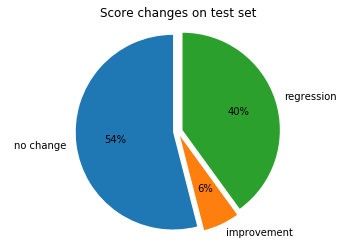

In [37]:
labels = ['no change', 'improvement', 'regression']
sizes = [54, 6, 40]
explode = [0.05, 0.05, 0.05]
plt.title('Score changes on test set')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.f%%',
        shadow=False, startangle=90)
plt.axis('equal')
plt.savefig('scores_pie.pdf')
plt.show()

In [ ]:
labels = ['no change', 'improvement', 'regression']
sizes = [82, 7, 11]
explode = [0.05, 0.05, 0.05]
plt.title('BLEU changes on test set')
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.f%%',
        shadow=False, startangle=90)
plt.axis('equal')
plt.savefig('bleu_pie.pdf')
plt.show()

In [7]:
perform_tests(k=100, initialization='greedy', temperature=0.4)

28-Year-Old Chef Found Dead at San Francisco Mall


A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.


But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."


The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.


The San Francisco Police Department said the death was ruled a homicide and an investigation is ongoing.


The victim's brother, Louis Galicia, told ABC station KGO in San Francisco that Frank, previously a line cook in Boston, had landed his dream job as line chef at San Francisco's Sons & Daughters restaurant six months ago.


KeyboardInterrupt: 

### Exponentiated gradient tests

In [4]:
res = perform_tests(k=100, initialization='greedy', temperature=1.0, optimizer='eg', start_lr=0.2)

28-Year-Old Chef Found Dead at San Francisco Mall


A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.


But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."


The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.


The San Francisco Police Department said the death was ruled a homicide and an investigation is ongoing.


The victim's brother, Louis Galicia, told ABC station KGO in San Francisco that Frank, previously a line cook in Boston, had landed his dream job as line chef at San Francisco's Sons & Daughters restaurant six months ago.


A spokesperson for Sons & Daughters said they were "shocked and devastated" by his death.


"We are a small team that operates like a close knit family and he will be dearly missed," the spokesperson said.


Our thoughts and condolences are with Frank's family and friends at this difficult time.


Louis Galicia said Frank initially stayed in hostels, but recently, "Things were finally going well for him."


"He found an apartment, he was dating a girl," Louis Galicia told KGO.


Louis Galicia said he could not think of anyone who would want to hurt his younger brother.


He was a kind spirit with a big heart.


His way of connecting with the family was always making us a dish, making us dinner," Louis Galicia said.


He never wanted to be in any kind of altercation.


He was the brother that went with the flow.


"With everything else that's going wrong with the world, he was that diamond in the rough that was shining bright every day," he said.


Anyone with information is asked to call the SFPD Tip Line at 415-575-4444.


Jennifer Aniston: I'm always pigeonholed


Jennifer Aniston need not always be perfect or successful.


That is what the Hollywood star has made abundantly clear in an interview.


"I'm always pigeonholed, or labelled by someone who has little, if anything, to do with me and reality."


"Personally, I have no desire to be perfect and successful all the time."


"To be honest, I don't really give a damn about things like that."


Jennifer Aniston (47) can only laugh that she has been dubbed "Miss Perfect" in the current issue of "Cosmopolitan".


The actress prefers to spend her time at home in front of the television with her hair in a relaxed bun, eating Mexican food, the magazine reports.


The question of whether she wants children makes her livid: "We women do not need to be married or have children to feel fulfilled," the Hollywood star says.


In her new film, "Mother's Day - love isn't child's play", Aniston stars as a single mother with two sons.


The film is released in Germany on 25 August.


Golfer Langer is awarded the Sport Pyramid


His experience on horseback is negligible.


At the end of a golfing tournament in South Africa, Bernhard Langer and a colleague went for a ride along the beach for a bit of fun.


It was a first for the 58-year-old.


CHIO: "Golden Sport Pyramid" for Bernhard Langer


After a few minutes, the horse decided it wanted to go home, and raced back to its feeding trough at full tilt.


After a kilometre at this speed I was scared.


"It wasn't a good experience," said Langer.


And with that, his riding career came to an end again.


On Saturday, Germany's best golfer of all time - with 101 tournament wins under his belt - was once again near horses.


He and his family toured the ALRV grounds, but he did not jump onto a horse for a photo.


It was Langer's first time in Aachen, and at CHIO.


He had been thoroughly convinced.


The German Sport Aid foundation awarded the man from Anhausen with the Golden Sport Pyramid at a small gala event.


The friendly sportsman is not lacking for awards.


The Federal Cross of Merit, the Silver Laurel Leaf, Champions Tour Player of the Year...


Even the British Queen has bestowed an honour upon him.


Langer is the 18th person to be awarded the Sport Pyramid.


On Saturday, he met the first person to receive it, Hans Günter Winkler, in Aachen.


"This award means a lot to me," said Langer, "because it's not just given for sporting success, but also for social commitment."


Langer has been encouraging up-and-coming talent for years.


And in this vein, he passed the prize money of 25,000 euros on straight away.


The two-time US master's champion was inaugurated into the "Hall of Fame for German Sport" on Saturday, along with 15 other outstanding sportspeople.


Those given the award include track athletes Hartwig Gauder and Harald Schmitt, gymnast Eberhard Gienger, fencers Cornelia Hanisch, Alexander Putsch and Arnd Schmitt, rower Peter-Michael Kolbe, bob-sleigh rider Meinhard Nehmer, judo player Frank Wieneke, show-jumper Alwin Schockemöhle, and, posthumously, handball player Erhard Wunderlich.
Many of these sport legends came to Aachen on Saturday.


After the official part, the illustrious gathering wandered to the show-jumping stadium, where the Lavazza Prize was underway.


Bernhard Langer kept his distance from the large animals.


Comparing Clinton's and Trump's economic policies: It's all about the money


Both Clinton and Trump want to invest in infrastructure and prevent the TTP trade agreement.


But the two candidates for the US presidency disagree on taxes and energy policies, as well as on one fundamental issue.


There is a fundamental philosophical reason for the differences between Donald Trump's and Hillary Clinton's economic policies.


This is the role of the state.


If in doubt, Trump wants the state's role to be minor, and warns of how the state can damage the economy with taxes and regulations.


Clinton wants to lead the economy to its death and regulate it to its death, he says.


He would do things totally differently, Trump says.


He would repeal regulations, and lead a wide-reaching tax reform with low rates for private individuals and companies.


Conversely, Clinton says that the state has particular tasks to fulfil, giving disadvantaged people opportunities - and it needs money to do so.


This would increase taxes for the rich, she says.


Interestingly, they have similar views on infrastructure.


There has to be investment in infrastructure, Trump and Clinton say almost verbatim.


The Democratic candidate has even announced the largest investment in jobs since the Second World War.


State programs investing in infrastructure are classic Democrat policies, and are rejected by the tea party wing of the Republican party, which is critical of the state.


Consequently, Trump could lead to discussions within the party.


There are clearer differences to be seen in terms of energy and climate policies.


Trump wants to build coal-fired power stations and bring coal production in the USA back up.


Drilling for oil should be permitted in protected areas, and he wants to withdraw from the Paris Climate Change Treaty.


On the other hand, Clinton wants to use her investment program to extend renewable energies, saying: "One country will become the superpower of renewable energies, and create millions of jobs."


"It will either be China, Germany or America - and I want it to be us."


But it's not just infrastructure that sees the two candidates taking a rather similar stance - they agree in terms of international trade agreements as well.


Neither want to sign TTP, the trans-Pacific trade agreement.


At the same time, neither want to cut the USA off from international trade - they just want to protect American jobs better.


They should then also be better paid, Clinton demands.


The current minimum wage of 7.25 US dollars is a pittance, she says.


She wants to raise it to 15 dollars an hour.


It is not quite clear what Trump wants to do on this score: Once he said that the minimum wage had to be raised, then he said it should stay the same.


But the big discussion of the months to come will likely revolve around both parties' tax policies.


Trump is on one side, wanting to relieve the burden on the economy and citizens to boost growth.


His critics state that this will just increase the budgetary deficit.


Clinton is on the opposite side: as a minimum, she wants the rich to pay more taxes, and her critics say that more taxes are not the solution either.


Seeking refuge: "Every refugee woman has dealt with sexual violence"


For women fleeing a country on their own, sexual violence is almost part of daily life.


When they arrive in Germany, they are often traumatised.


One house offers refuge.


Four women are sitting in a large kitchen.


Every one of them has a baby with them, the oldest of which is one year old.


One woman holds her little son in her arms.


He looks around the room inquisitively, his eyes wide.


His mother stares at the tabletop.


Until she realises she's being watched.


She smiles briefly and kisses the child.


The scene looks normal.


Total statistics (tested on 100 sentences)
1 sentences st. continuous optimization failed
1 sentences with better score (1.0%)
77 sentences without change in score (77.0%)
21 sentences with worse score (21.0%)
3 sentences with better bleu (3.0%)
89 sentences without change in bleu (89.0%)
7.0 sentences with worse bleu (7.0%)
Average BLEU before continuous optimization: 29.38809999999999
Average BLEU after continuous optimization: 29.157999999999987
Average dscore before continuous optimization: 0.4591788101196289
Average dscore after continuous optimization: 0.5678982543945312


In [4]:
res = perform_tests(k=100, initialization='greedy', temperature=1.0, optimizer='eg', start_lr=0.1)

28-Year-Old Chef Found Dead at San Francisco Mall


A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.


But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."


The body found at the Westfield Mall Wednesday morning was identified as 28-year-old San Francisco resident Frank Galicia, the San Francisco Medical Examiner's Office said.


The San Francisco Police Department said the death was ruled a homicide and an investigation is ongoing.


The victim's brother, Louis Galicia, told ABC station KGO in San Francisco that Frank, previously a line cook in Boston, had landed his dream job as line chef at San Francisco's Sons & Daughters restaurant six months ago.


A spokesperson for Sons & Daughters said they were "shocked and devastated" by his death.


"We are a small team that operates like a close knit family and he will be dearly missed," the spokesperson said.


Our thoughts and condolences are with Frank's family and friends at this difficult time.


Louis Galicia said Frank initially stayed in hostels, but recently, "Things were finally going well for him."


"He found an apartment, he was dating a girl," Louis Galicia told KGO.


Louis Galicia said he could not think of anyone who would want to hurt his younger brother.


He was a kind spirit with a big heart.


His way of connecting with the family was always making us a dish, making us dinner," Louis Galicia said.


He never wanted to be in any kind of altercation.


He was the brother that went with the flow.


"With everything else that's going wrong with the world, he was that diamond in the rough that was shining bright every day," he said.


Anyone with information is asked to call the SFPD Tip Line at 415-575-4444.


Jennifer Aniston: I'm always pigeonholed


Jennifer Aniston need not always be perfect or successful.


That is what the Hollywood star has made abundantly clear in an interview.


"I'm always pigeonholed, or labelled by someone who has little, if anything, to do with me and reality."


"Personally, I have no desire to be perfect and successful all the time."


"To be honest, I don't really give a damn about things like that."


Jennifer Aniston (47) can only laugh that she has been dubbed "Miss Perfect" in the current issue of "Cosmopolitan".


The actress prefers to spend her time at home in front of the television with her hair in a relaxed bun, eating Mexican food, the magazine reports.


The question of whether she wants children makes her livid: "We women do not need to be married or have children to feel fulfilled," the Hollywood star says.


In her new film, "Mother's Day - love isn't child's play", Aniston stars as a single mother with two sons.


The film is released in Germany on 25 August.


Golfer Langer is awarded the Sport Pyramid


His experience on horseback is negligible.


At the end of a golfing tournament in South Africa, Bernhard Langer and a colleague went for a ride along the beach for a bit of fun.


It was a first for the 58-year-old.


CHIO: "Golden Sport Pyramid" for Bernhard Langer


After a few minutes, the horse decided it wanted to go home, and raced back to its feeding trough at full tilt.


After a kilometre at this speed I was scared.


"It wasn't a good experience," said Langer.


And with that, his riding career came to an end again.


On Saturday, Germany's best golfer of all time - with 101 tournament wins under his belt - was once again near horses.


He and his family toured the ALRV grounds, but he did not jump onto a horse for a photo.


It was Langer's first time in Aachen, and at CHIO.


He had been thoroughly convinced.


The German Sport Aid foundation awarded the man from Anhausen with the Golden Sport Pyramid at a small gala event.


The friendly sportsman is not lacking for awards.


The Federal Cross of Merit, the Silver Laurel Leaf, Champions Tour Player of the Year...


Even the British Queen has bestowed an honour upon him.


Langer is the 18th person to be awarded the Sport Pyramid.


On Saturday, he met the first person to receive it, Hans Günter Winkler, in Aachen.


"This award means a lot to me," said Langer, "because it's not just given for sporting success, but also for social commitment."


Langer has been encouraging up-and-coming talent for years.


And in this vein, he passed the prize money of 25,000 euros on straight away.


The two-time US master's champion was inaugurated into the "Hall of Fame for German Sport" on Saturday, along with 15 other outstanding sportspeople.


Those given the award include track athletes Hartwig Gauder and Harald Schmitt, gymnast Eberhard Gienger, fencers Cornelia Hanisch, Alexander Putsch and Arnd Schmitt, rower Peter-Michael Kolbe, bob-sleigh rider Meinhard Nehmer, judo player Frank Wieneke, show-jumper Alwin Schockemöhle, and, posthumously, handball player Erhard Wunderlich.


Many of these sport legends came to Aachen on Saturday.


After the official part, the illustrious gathering wandered to the show-jumping stadium, where the Lavazza Prize was underway.


Bernhard Langer kept his distance from the large animals.


Comparing Clinton's and Trump's economic policies: It's all about the money


Both Clinton and Trump want to invest in infrastructure and prevent the TTP trade agreement.


But the two candidates for the US presidency disagree on taxes and energy policies, as well as on one fundamental issue.


There is a fundamental philosophical reason for the differences between Donald Trump's and Hillary Clinton's economic policies.


This is the role of the state.


If in doubt, Trump wants the state's role to be minor, and warns of how the state can damage the economy with taxes and regulations.


Clinton wants to lead the economy to its death and regulate it to its death, he says.


He would do things totally differently, Trump says.


He would repeal regulations, and lead a wide-reaching tax reform with low rates for private individuals and companies.


Conversely, Clinton says that the state has particular tasks to fulfil, giving disadvantaged people opportunities - and it needs money to do so.


This would increase taxes for the rich, she says.


Interestingly, they have similar views on infrastructure.


There has to be investment in infrastructure, Trump and Clinton say almost verbatim.


The Democratic candidate has even announced the largest investment in jobs since the Second World War.


State programs investing in infrastructure are classic Democrat policies, and are rejected by the tea party wing of the Republican party, which is critical of the state.


Consequently, Trump could lead to discussions within the party.


There are clearer differences to be seen in terms of energy and climate policies.


Trump wants to build coal-fired power stations and bring coal production in the USA back up.


Drilling for oil should be permitted in protected areas, and he wants to withdraw from the Paris Climate Change Treaty.


On the other hand, Clinton wants to use her investment program to extend renewable energies, saying: "One country will become the superpower of renewable energies, and create millions of jobs."


"It will either be China, Germany or America - and I want it to be us."


But it's not just infrastructure that sees the two candidates taking a rather similar stance - they agree in terms of international trade agreements as well.


Neither want to sign TTP, the trans-Pacific trade agreement.


At the same time, neither want to cut the USA off from international trade - they just want to protect American jobs better.


They should then also be better paid, Clinton demands.


The current minimum wage of 7.25 US dollars is a pittance, she says.


She wants to raise it to 15 dollars an hour.


It is not quite clear what Trump wants to do on this score: Once he said that the minimum wage had to be raised, then he said it should stay the same.


But the big discussion of the months to come will likely revolve around both parties' tax policies.


Trump is on one side, wanting to relieve the burden on the economy and citizens to boost growth.


His critics state that this will just increase the budgetary deficit.


Clinton is on the opposite side: as a minimum, she wants the rich to pay more taxes, and her critics say that more taxes are not the solution either.


Seeking refuge: "Every refugee woman has dealt with sexual violence"


For women fleeing a country on their own, sexual violence is almost part of daily life.


When they arrive in Germany, they are often traumatised.


One house offers refuge.


Four women are sitting in a large kitchen.


Every one of them has a baby with them, the oldest of which is one year old.


One woman holds her little son in her arms.


He looks around the room inquisitively, his eyes wide.


His mother stares at the tabletop.


Until she realises she's being watched.


She smiles briefly and kisses the child.


The scene looks normal.


Total statistics (tested on 100 sentences)
0 sentences with better score (0.0%)
84 sentences without change in score (84.0%)
16 sentences with worse score (16.0%)
1 sentences with better bleu (1.0%)
95 sentences without change in bleu (95.0%)
4.0 sentences with worse bleu (4.0%)
Average BLEU before continuous optimization: 29.92579999999999
Average BLEU after continuous optimization: 29.814699999999988
Average dscore before continuous optimization: 0.4621334457397461
Average dscore after continuous optimization: 0.5332257080078125


### Analysis on good examples

In [7]:
tr1 = perform_detailed_test(2)

But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."


In [8]:
tr2 = perform_detailed_test(7) # tutaj po podmianie jednego słowa koszt najpierw wzrasta, a potem po podmianie innego jest niższy niż pierwotnie

"We are a small team that operates like a close knit family and he will be dearly missed," the spokesperson said.


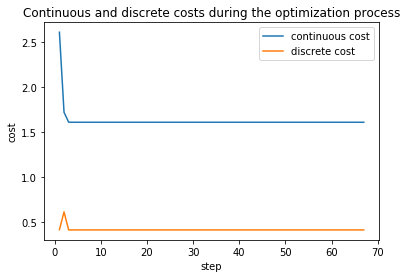

In [29]:
plot_costs(tr2, 'costs2.pdf')

In [6]:
perform_detailed_test(35)

After a kilometre at this speed I was scared.


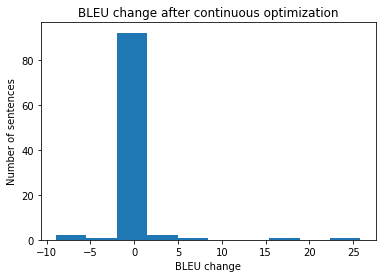

In [24]:
plt.rcParams.update({
"pgf.texsystem": "pdflatex",
"pgf.preamble": [
    r"\usepackage[utf8x]{inputenc}",
    r"\usepackage[T1]{fontenc}",
    r"\usepackage{cmbright}",
]})
    
def bleu_histogram(res, file):
    gscore, gbleu, cscore, cbleu = res
    delta_bleu = np.array(cbleu) - np.array(gbleu)
    plt.title('BLEU change after continuous optimization')
    plt.xlabel('BLEU change')
    plt.ylabel('Number of sentences')
    plt.hist(delta_bleu)
    plt.savefig(file)
    
bleu_histogram(res, 'bleu_hist.pdf')
    

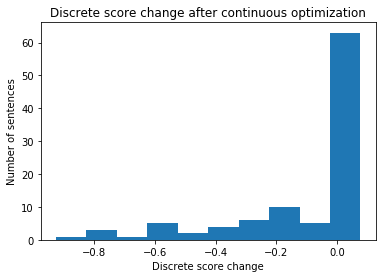

In [26]:
def score_histogram(res, file):
    gscore, gbleu, cscore, cbleu = res
    delta_score = np.array(gscore) - np.array(cscore)
    plt.title('Discrete score change after continuous optimization')
    plt.xlabel('Discrete score change')
    plt.ylabel('Number of sentences')
    plt.hist(delta_score)
    plt.savefig(file)
    
score_histogram(res, 'score_hist.pdf')

In [7]:
perform_detailed_test(39)

He and his family toured the ALRV grounds, but he did not jump onto a horse for a photo.


### Analysis on worse examples (T=1.0)

In [8]:
perform_detailed_test(6)

A spokesperson for Sons & Daughters said they were "shocked and devastated" by his death.


In [9]:
perform_detailed_test(15)

He was the brother that went with the flow.


### Good examples (T=0.5)

In [10]:
perform_detailed_test(2, temperature=0.5)

But the victim's brother says he can't think of anyone who would want to hurt him, saying, "Things were finally going well for him."


In [12]:
perform_detailed_test(7, temperature=0.5)

"We are a small team that operates like a close knit family and he will be dearly missed," the spokesperson said.


In [13]:
perform_detailed_test(35, temperature=0.5)

After a kilometre at this speed I was scared.


In [14]:
perform_detailed_test(39, temperature=0.5)

He and his family toured the ALRV grounds, but he did not jump onto a horse for a photo.


### Analysis on worse examples (T=0.5)

In [16]:
perform_detailed_test(6, temperature=0.5)

A spokesperson for Sons & Daughters said they were "shocked and devastated" by his death.


### Comparison greedy vs beam

In [19]:
data = compare_beam_greedy(4, return_aligned=True)

The San Francisco Police Department said the death was ruled a homicide and an investigation is ongoing.


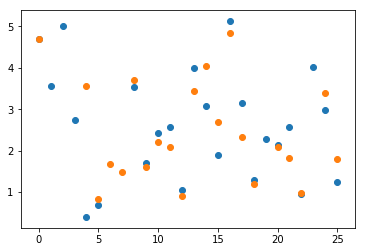

In [20]:
plot_entropies(data[0], data[1], data[2], data[3])

In [17]:
probs = other_candidates(4, data[0], 0)

The San Francisco Police Department said the death was ruled a homicide and an investigation is ongoing.
▁Die ▁Polizei abteilung ▁von ▁San ▁Francisco ▁sagte , ▁dass ▁der ▁Tod ▁eines ▁Mord es ▁be urteil t ▁wurde ▁und ▁eine ▁Untersuchung ▁an hält .
Best candidates on position 0 :  ▁Die ▁Das ▁Der ▁In ▁Nach
Coresponding probabilities: [0.32211372, 0.1306425, 0.0507547, 0.025292495, 0.023973096]


In [14]:
'$ & $'.join(np.around(-np.sum(np.log(data[1]) * data[1], axis=1), 2).astype('str'))

'4.7$ & $3.56$ & $5.02$ & $2.75$ & $0.39$ & $0.68$ & $3.53$ & $1.71$ & $2.43$ & $2.58$ & $1.05$ & $4.0$ & $3.08$ & $1.89$ & $5.14$ & $3.16$ & $1.3$ & $2.27$ & $2.13$ & $2.58$ & $0.95$ & $4.03$ & $2.99$ & $1.24$ & $1.21'

In [52]:
probs

array([[3.4806062e-06, 1.4545953e-14, 3.4806394e-06, ..., 3.4823793e-06,
        3.4801615e-06, 3.4465645e-06],
       [3.5966416e-06, 5.0218752e-16, 3.5966345e-06, ..., 3.6113934e-06,
        3.5969467e-06, 3.5901476e-06],
       [4.3803716e-06, 1.2734688e-16, 4.3803925e-06, ..., 4.4200692e-06,
        4.3816876e-06, 4.3900950e-06],
       ...,
       [2.2889001e-06, 6.6177638e-18, 2.2889744e-06, ..., 2.3365969e-06,
        2.2886970e-06, 2.4170024e-06],
       [2.7480976e-06, 2.1434329e-16, 2.7481710e-06, ..., 2.7554456e-06,
        2.7479116e-06, 2.7859114e-06],
       [2.7526457e-06, 1.8023043e-14, 2.7526878e-06, ..., 2.7538090e-06,
        2.7525462e-06, 2.7568965e-06]], dtype=float32)

In [11]:
probs == data[1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

### Beam tests

In [6]:
import pickle
class BeamTestResult(object):
    
    def __init__(self, translations, scores, bleus):
        self.translations = translations
        self.scores = scores
        self.bleus = bleus
    
    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f, pickle.HIGHEST_PROTOCOL)
            
    
def beam_test(k=50, beamsize=15, temperature=1.):
    scorer = Scorer(temperature=temperature)
    english_sentences = load_test_data(english_path)
    references = load_reference_data(german_path)    
    i = 0
    bleus = []
    scores = []
    translations = []
    bleu_score = 0.
    for english_sentence, reference in zip(english_sentences[:k], references):
        i += 1
        print('Sentence', i)
        print(english_sentence)
        english_tok = tokenizer.tokenize(english_sentence)
        optimizer = BeamOptimizer(english_sentence, beamsize, temperature=temperature)
        translation = optimizer.optimize()[0][0][:-1]
        print(' '.join(translation))
        score = -scorer.score_tokenized_texts([english_tok], [translation], relaxed=False, normalize=True).item()
        obleu = bleu(reference, ' '.join(translation))
        print('dscore = ', score)
        print('bleu = ', obleu)
        print()
        
        bleu_score += obleu
        bleus += [obleu]
        scores += [score]
        translations += [translation]
        
    print('Beam size = ', beamsize, 'avg bleu = ', float(bleu_score) / k)
    res = BeamTestResult(translations, scores, bleus)
    res.save(f'beam_test_{k}_{beamsize}.pkl')
    return res

In [7]:
beam_test(k=1, beamsize=1)

Sentence 1
28-Year-Old Chef Found Dead at San Francisco Mall
▁28 - Jahr - O ld ▁Chef ▁Found ▁Dead
dscore =  0.5151540637016296
bleu =  0.0

Beam size =  1 avg bleu =  0.0


In [8]:
with open('beam_test_1_1.pkl', 'rb') as f:
    res = pickle.load(f)
    print(res.translations)

[['▁28', '-', 'Jahr', '-', 'O', 'ld', '▁Chef', '▁Found', '▁Dead']]
